# **GStore (Google Merchandise Store) Customers Spending Prediction**
Predict how much per GStore customer will spend (based on [Kaggle challenge](https://www.kaggle.com/c/ga-customer-revenue-prediction/overview)).

# Part 1: Data Loading and Preprocessing

## 1.1 Load Data

### 1.1.1 Packages

In [ ]:
import numpy as np
import pandas as pd
import json
from pandas import json_normalize
from google.colab import drive

drive.mount("./ggdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./ggdrive


### 1.1.2 Data Load

In [ ]:
def dLoad(fpath="ggdrive/My Drive/dataSet/GStore/train.csv", jsons=None):
  dtrain = pd.read_csv(fpath, converters={col: json.loads for col in jsons}, dtype={"fullVisitorId": "str"})
  for col in jsons:
    col_df = json_normalize(dtrain[col])
    #print(f'{col}: ', [f'{ks}' for ks in col_df.columns])
    col_df.columns = [f"{col}.{ks}" for ks in col_df.columns]
    dtrain = dtrain.drop(col, axis=1).merge(col_df, left_index=True, right_index=True)
  print(dtrain.shape)
  return dtrain

dtrain = dLoad(jsons = ['device', 'geoNetwork', 'totals', 'trafficSource'])

(903653, 55)


### 1.1.3 First glance of the data

In [ ]:
dtrain.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [ ]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [ ]:
dtrain.isna().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
sessionId                                                 0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserVersion                                     0
device.browserSize                                        0
device.operatingSystem                                    0
device.operatingSystemVersion                             0
device.isMobile                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceModel                                  0
device.mobileInputSelector              

In [ ]:
dtrain.nunique()

channelGrouping                                           8
date                                                    366
fullVisitorId                                        714167
sessionId                                            902755
socialEngagementType                                      1
visitId                                              886303
visitNumber                                             384
visitStartTime                                       887159
device.browser                                           54
device.browserVersion                                     1
device.browserSize                                        1
device.operatingSystem                                   20
device.operatingSystemVersion                             1
device.isMobile                                           2
device.mobileDeviceBranding                               1
device.mobileDeviceModel                                  1
device.mobileInputSelector              

### 1.1.4 Remove columns with only one notnull values

In [ ]:
dtrain['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
dtrain['trafficSource.isTrueDirect'].fillna(False, inplace=True)

# remove columns with only one distinct value
dtrain.drop(dtrain.columns[dtrain.nunique() == 1], axis=1, inplace=True)
dtrain.nunique()

channelGrouping                                      8
date                                               366
fullVisitorId                                   714167
sessionId                                       902755
visitId                                         886303
visitNumber                                        384
visitStartTime                                  887159
device.browser                                      54
device.operatingSystem                              20
device.isMobile                                      2
device.deviceCategory                                3
geoNetwork.continent                                 6
geoNetwork.subContinent                             23
geoNetwork.country                                 222
geoNetwork.region                                  376
geoNetwork.metro                                    94
geoNetwork.city                                    649
geoNetwork.networkDomain                         28064
totals.hit

## 1.2 Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.2.1 Transaction Information for Per-VisitorId

consumers/visitors = 9996/714167 = 1.40%
consumRcords/visitings = 11515/903653 = 1.27%


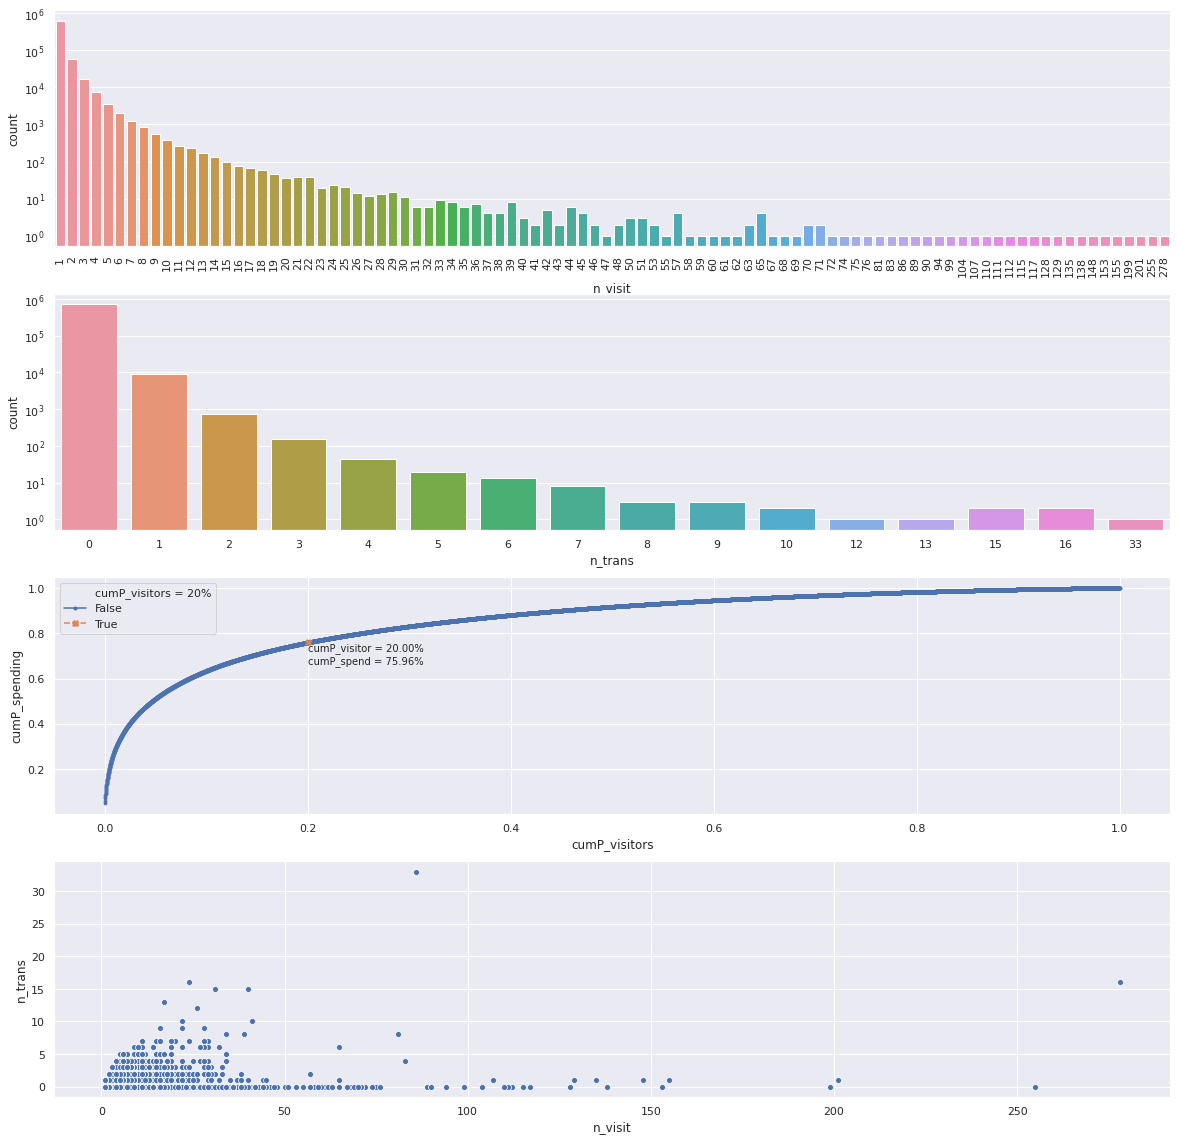

In [ ]:
dtrain['totals.transactionRevenue'] = dtrain['totals.transactionRevenue'].astype('float')
df1 = dtrain.groupby(['fullVisitorId'])['totals.transactionRevenue'].agg(['size', 'count', 'sum'])
df1.columns = ['n_visit', 'n_trans', 'total_spending']
df1['freq_visit'] = df1.groupby(['n_visit'])['n_trans'].transform(lambda x: x.shape[0] / df1.shape[0])
df1['freq_trans'] = df1.groupby(['n_trans'])['n_visit'].transform(lambda x: x.shape[0] / df1.shape[0])
#df1['freq_spend'] = df1.groupby(['total_spending'])['n_trans'].transform(lambda x: x.shape[0] / df1.shape[0])
df2 = df1[df1.total_spending > 0][['total_spending']].sort_values(by=['total_spending'], ascending=False)
df2['cumP_spending'] = (df2['total_spending']/df2['total_spending'].sum()).cumsum()
df2['cumP_visitors'] = np.arange(1, df2.shape[0]+1) / df2.shape[0]
#print(df2)

n_consumers = (df1.n_trans > 0).sum()
n_consumRcords = df1.n_trans.sum()
print('consumers/visitors = {}/{} = {:.2f}%'.format(n_consumers, df1.shape[0], n_consumers/df1.shape[0]*100))
print('consumRcords/visitings = {}/{} = {:.2f}%'.format(n_consumRcords, dtrain.shape[0], n_consumRcords/dtrain.shape[0]*100))

fig, axs = plt.subplots(4, 1, figsize=[20, 20])
sns.countplot(x='n_visit', data=df1, ax=axs[0])
axs[0].tick_params(axis='x', rotation=90)
axs[0].set(yscale='log')
#axs[0].set_title('n_visit')

sns.countplot(x='n_trans', data=df1, ax=axs[1])
axs[1].set(yscale='log')

cumP_v = min(abs(df2.cumP_visitors - 0.20))
df2['cumP_visitors = 20%'] = (abs(df2.cumP_visitors - 0.20) == cumP_v)
sns.lineplot(x='cumP_visitors', y='cumP_spending', hue='cumP_visitors = 20%', \
             style='cumP_visitors = 20%', markers=['.', 'X'], data=df2, \
             mec=None, ax=axs[2])
#print(df2[df2['cumP_visitors = 20%']].head())
x, y = df2[df2['cumP_visitors = 20%']][['cumP_visitors', 'cumP_spending']].values.reshape(2)
axs[2].text(x, y, 'cumP_visitor = {:.2f}%\ncumP_spend = {:.2f}%'.format(x*100, y*100),\
            horizontalalignment='left', verticalalignment='top')

_ = sns.scatterplot(x='n_visit', y='n_trans', data=df1, ax=axs[3])

### 1.2.2 Consuming vs. Visiting Time Series

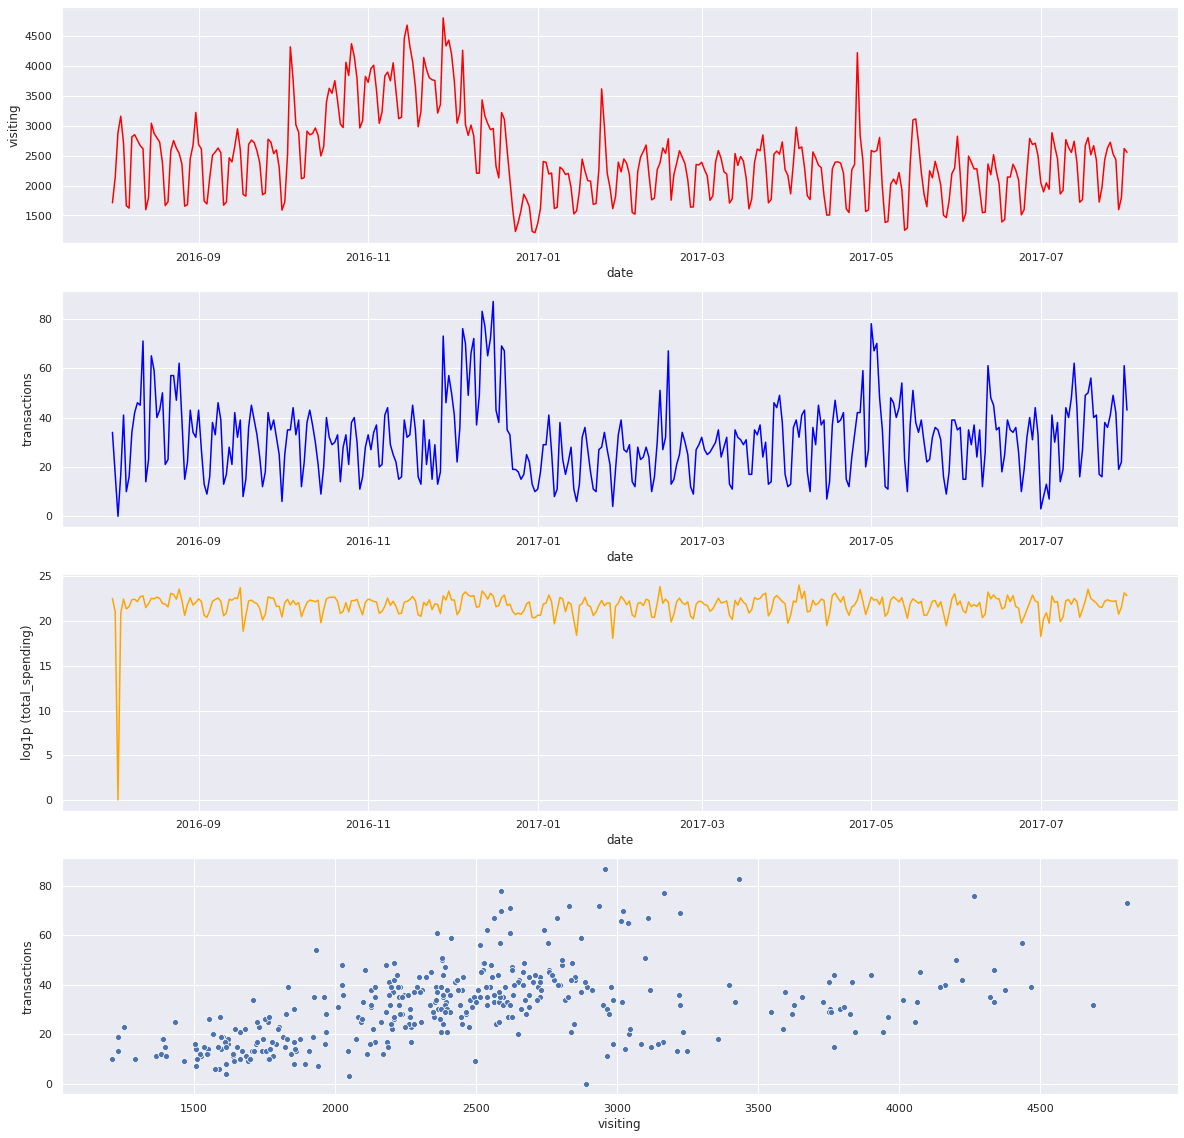

In [ ]:
dtrain['date'] = pd.to_datetime(dtrain['date'], format='%Y%m%d').dt.floor('d')
df1 = dtrain.groupby('date')['totals.transactionRevenue'].agg(['size', 'count', 'sum'])
df1.columns = ['visiting', 'transactions', 'total_spending']

fig, axs = plt.subplots(4, 1, figsize=[20, 20])
sns.lineplot(x=df1.index, y='visiting', data=df1, ax=axs[0], color='red')
sns.lineplot(x=df1.index, y='transactions', data=df1, ax=axs[1], color='blue')
sns.lineplot(x=df1.index, y=np.log1p(df1['total_spending']), ax=axs[2], color='orange')
axs[2].set_ylabel('log1p (total_spending)')
sns.scatterplot(x='visiting', y='transactions', data=df1, ax=axs[3])
plt.show()

**Summay：** Looks like there no correlation between date and spending.

### 1.2.3 Explore and Visualize Categorical Features

#### 1.2.3.0 Define function

In [ ]:
def visualFeats(df, x, y='totals.transactionRevenue', hueCol='Transaction?'):
  df1 = df.loc[:, [x, y]]
  df1[hueCol] = df1[y].notna()
  df2 = df1.groupby([x, hueCol])[y].agg(['size', 'sum'])
  df2.columns = ['numVisit', 'transactionRevenue']
  df2.reset_index(inplace=True)
  xorder = df2.loc[df2[hueCol], [x, 'transactionRevenue']].sort_values(by='transactionRevenue', ascending=False)[x]
  #print(df2)

  fig, axs = plt.subplots(2, 1, figsize=[20, 10])
  sns.barplot(x=x, y='numVisit', hue=hueCol, order=xorder, data=df2, ax=axs[0])
  axs[0].set_yscale('log')
  if len(xorder) > 10:
    axs[0].tick_params(axis='x', rotation=90)

  sns.barplot(x=x, y='transactionRevenue', order=xorder, data=df2[df2[hueCol]], ax=axs[1])
  axs[1].set_yscale('log')
  if len(xorder) > 10:
    axs[1].tick_params(axis='x', rotation=90)

#### 1.2.3.1 Categorical feature "channelGrouping"

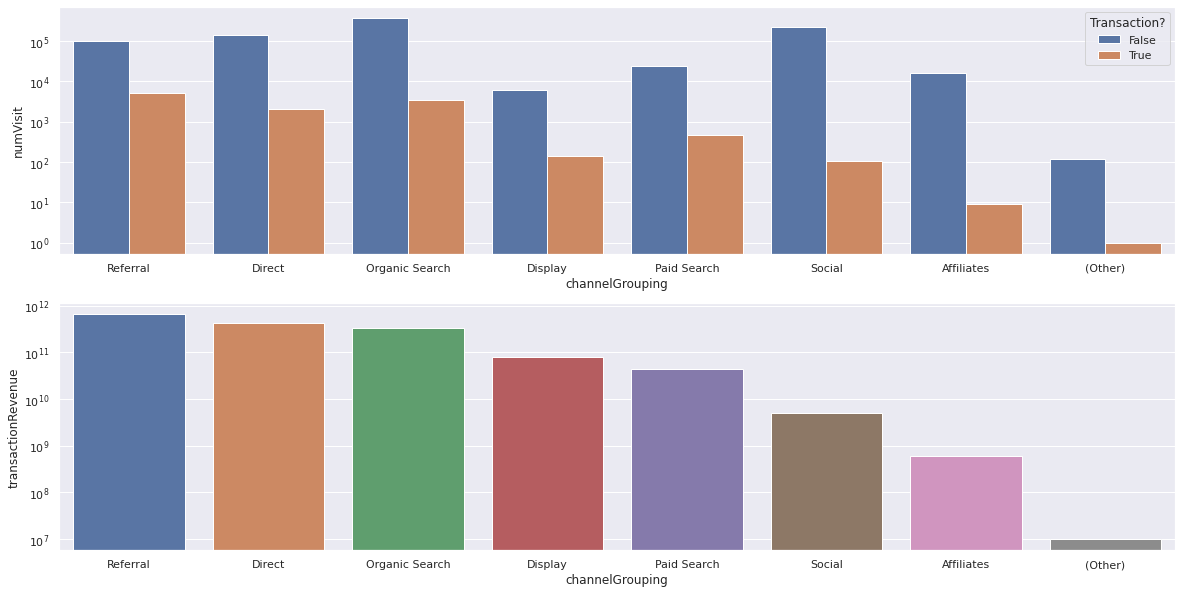

In [ ]:
visualFeats(dtrain, 'channelGrouping')

#### 1.2.3.2 Categorical feature "device.operatingSystem"

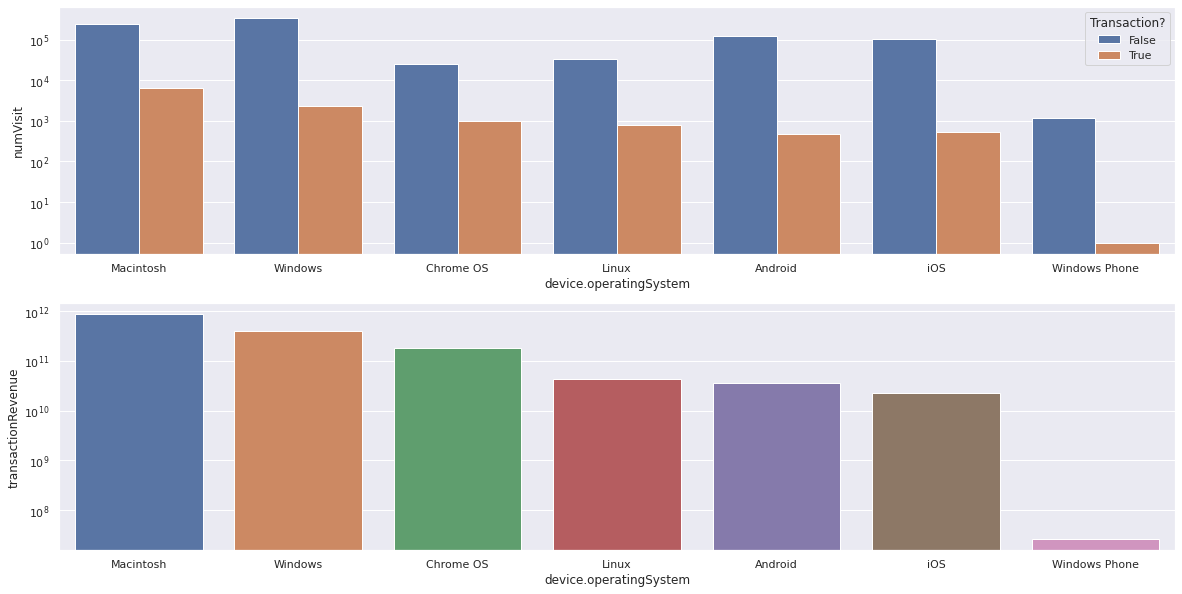

In [ ]:
visualFeats(dtrain, 'device.operatingSystem')

#### 1.2.3.3 Categorical feature "geoNetwork.continent"

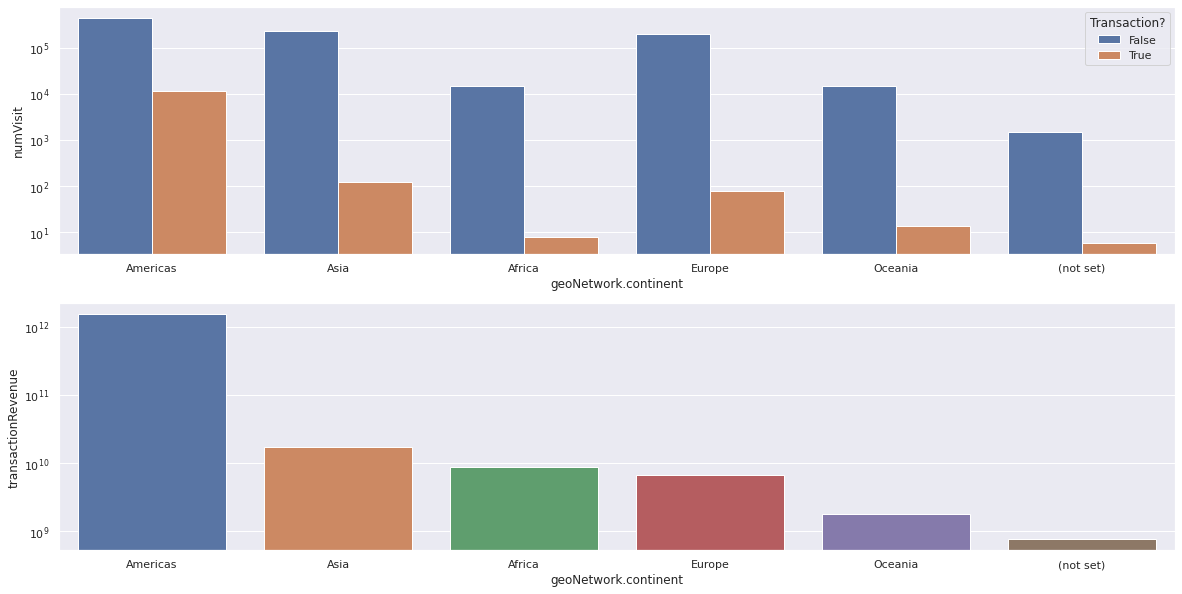

In [ ]:
visualFeats(dtrain, 'geoNetwork.continent')

#### 1.2.3.4 Categorical feature "geoNetwork.metro"

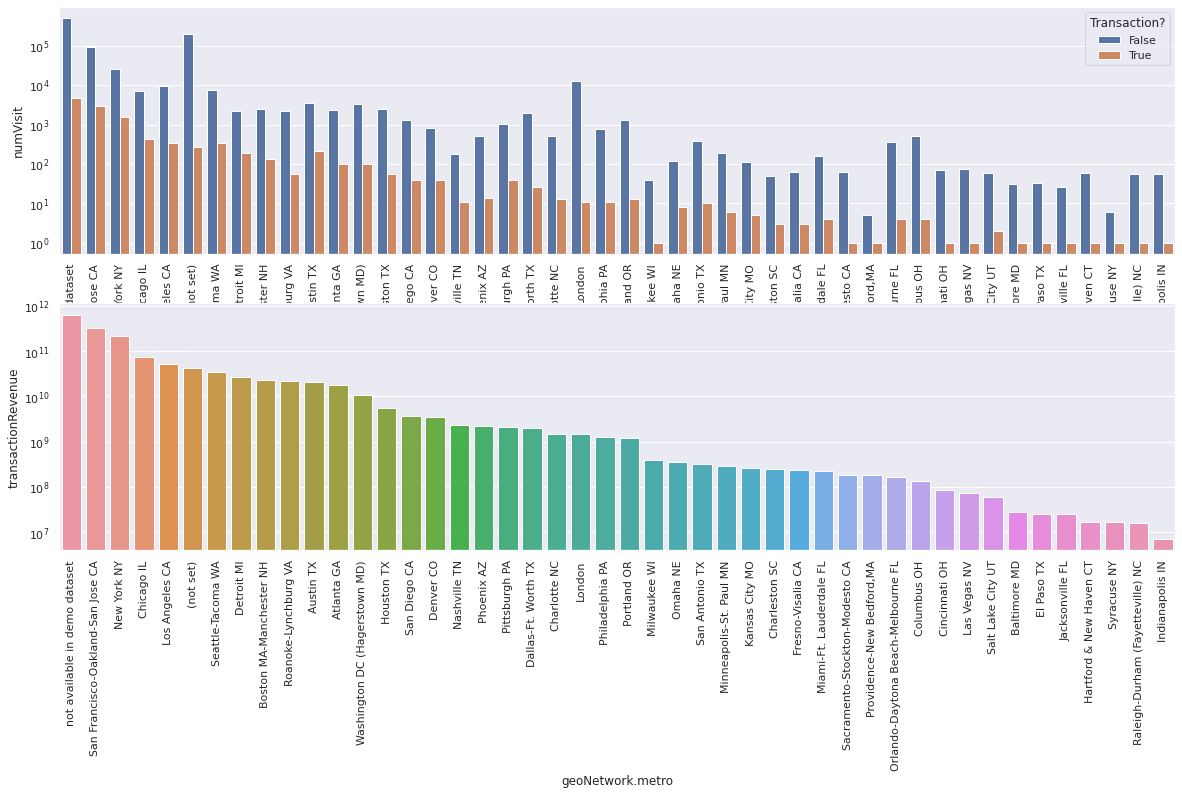

In [ ]:
visualFeats(dtrain, 'geoNetwork.metro')

#### 1.2.3.5 Feature "totals.pageviews"

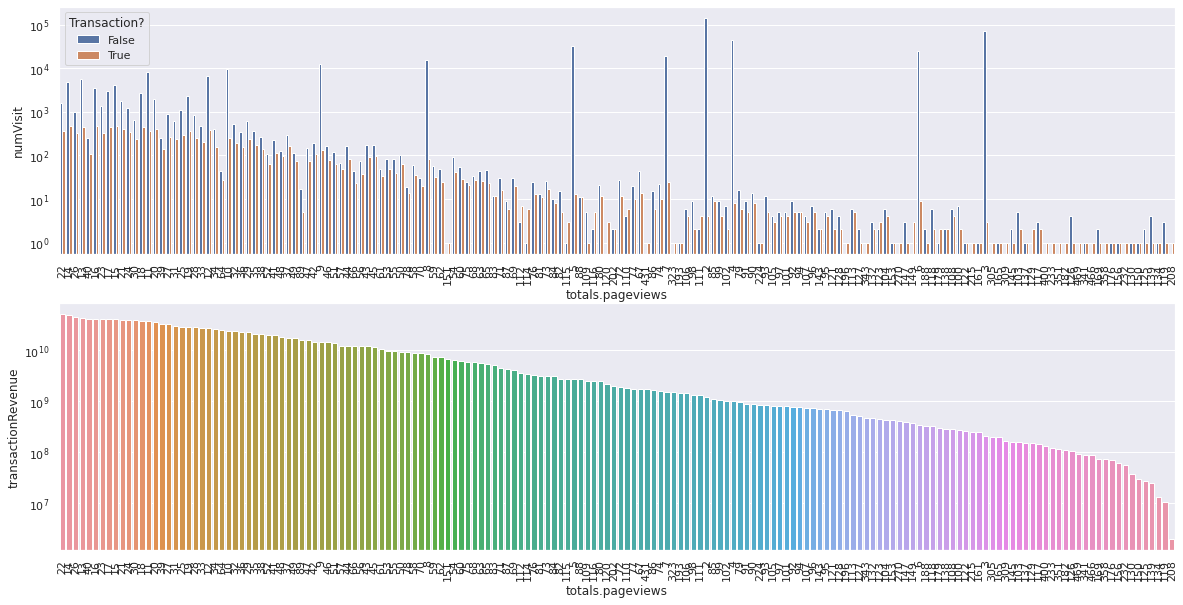

In [ ]:
visualFeats(dtrain, 'totals.pageviews')

#### 1.2.3.6 Categorical feature "trafficSource.campaign"

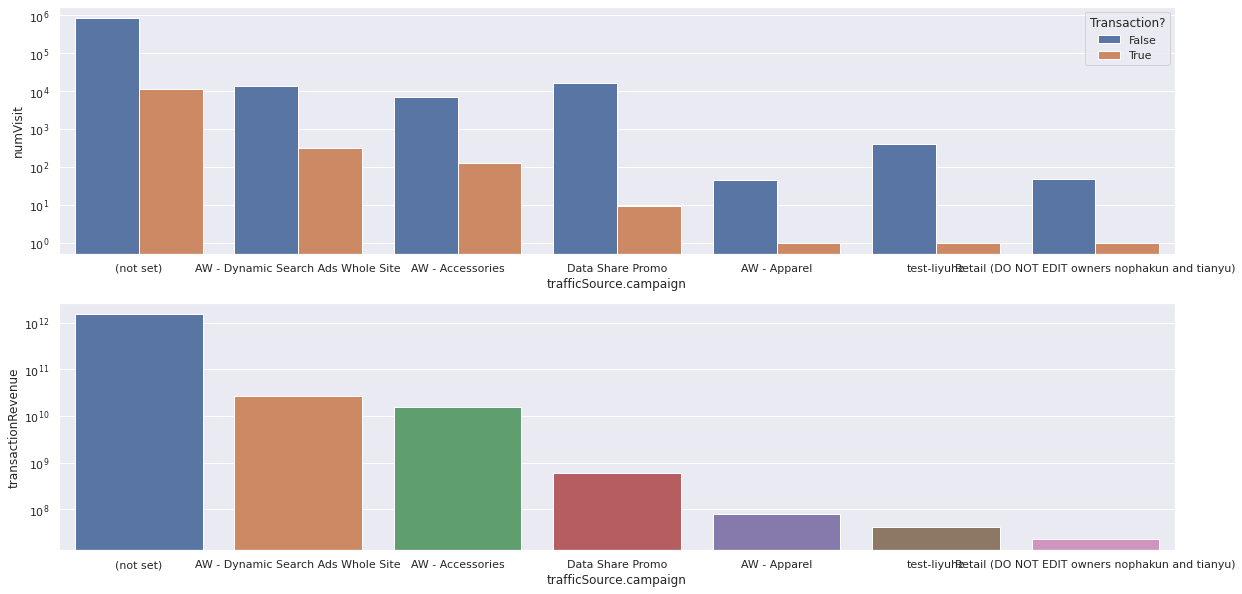

In [ ]:
visualFeats(dtrain, 'trafficSource.campaign')

#### 1.2.3.7 Categorical feature "trafficSource.medium"

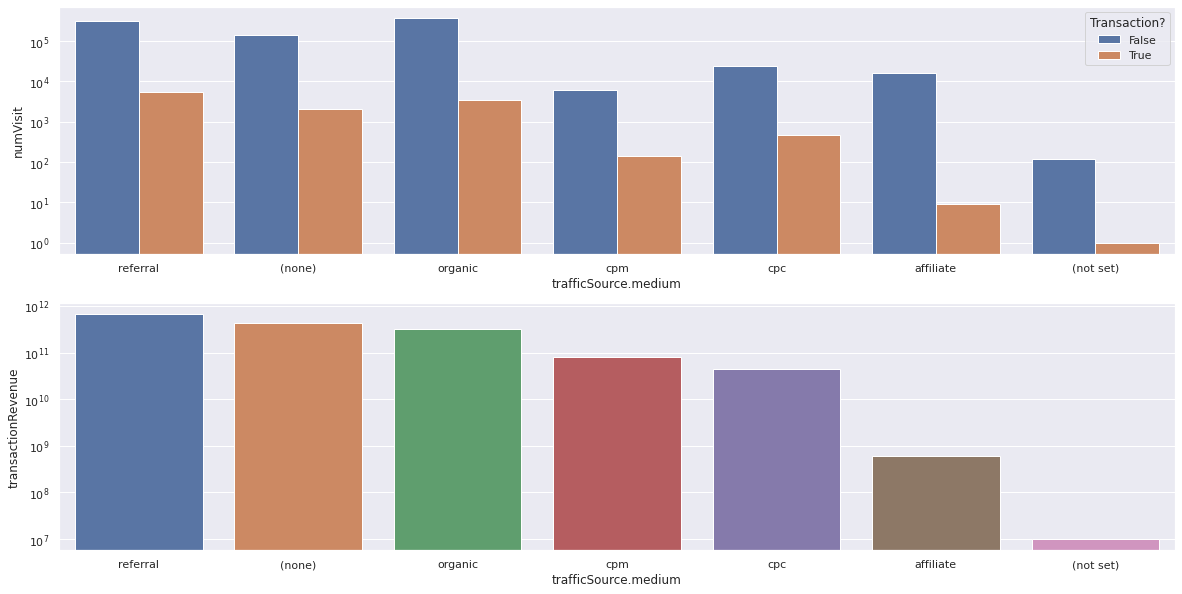

In [ ]:
visualFeats(dtrain, 'trafficSource.medium')

## 1.3 Feature Engineering



### 1.3.1 Numerical Columns

#### 1.3.1.1 Apply np.log1p to smooth numerical features

In [ ]:
num_cols = ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue'] #, 'totals.bounces', 'totals.newVisits'

for col in num_cols:
  dtrain[col] = dtrain[col].astype(float)
  dtrain[col] = dtrain[col].fillna(0)
  dtrain[col] = np.log1p(dtrain[col])

#### 1.3.1.2 MinMaxScaler Numerical Values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

num_MinMaxSc = MinMaxScaler(feature_range=(0, 1))
dtrain[num_cols] = num_MinMaxSc.fit_transform(dtrain[num_cols])
print(num_MinMaxSc.data_max_)

[ 5.98141421  6.2166061   6.15273269 23.8643747 ]


### 1.3.2 Categorical Columns

#### 1.3.2.1 Fill out all missing values with "missing"

In [ ]:
dtrain['trafficSource.keyword'] = dtrain['trafficSource.keyword'].fillna('missing')
#dtrain['trafficSource.referralPath'] = dtrain['trafficSource.referralPath'].fillna('missing')
dtrain['trafficSource.adwordsClickInfo.page'] = dtrain['trafficSource.adwordsClickInfo.page'].fillna('missing')
dtrain['trafficSource.adwordsClickInfo.slot'] = dtrain['trafficSource.adwordsClickInfo.slot'].fillna('missing')
dtrain['trafficSource.adwordsClickInfo.gclId'] = dtrain['trafficSource.adwordsClickInfo.gclId'].fillna('missing')
dtrain['trafficSource.adwordsClickInfo.adNetworkType'] = dtrain['trafficSource.adwordsClickInfo.adNetworkType'].fillna('missing')
dtrain['trafficSource.adContent'] = dtrain['trafficSource.adContent'].fillna('missing')

#### 1.3.2.2 Combine columns

In [ ]:
#dtrain['browser_category'] = dtrain['device.browser'] + '_' + dtrain['device.deviceCategory']
#dtrain['browser_operatingSystem'] = dtrain['device.browser'] + '_' + dtrain['device.operatingSystem']
#dtrain['source_country'] = dtrain['trafficSource.source'] + '_' + dtrain['geoNetwork.country']

#### 1.3.2.3 Numerical columns and Categorical columns

In [ ]:
no_use = ["date", "fullVisitorId", "sessionId", "visitId", "visitStartTime", 'totals.transactionRevenue', 'trafficSource.referralPath']
cat_cols = [col for col in dtrain.columns if col not in num_cols and col not in no_use]
print(num_cols, cat_cols)

['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue'] ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.isMobile', 'device.deviceCategory', 'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain', 'trafficSource.campaign', 'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent']


### 1.3.3 Categorical Feature Encoding

In [ ]:
n_val = 50
encoding_dict = dict() # will be used for test data
cat_cols1 = []
cat_cols2 = []
d_embs1 = []
d_embs2 = []
for col in cat_cols:
  vals = dtrain[col].value_counts().index.tolist()
  le = {val: i for i, val in enumerate(vals, 1)}
  encoding_dict[col] = le
  nn = len(vals)
  if nn <= n_val:
    cat_cols1.append(col)
    d_embs1.append((nn + 1, min(nn // 2 + 1, n_val)))
  else:
    cat_cols2.append(col)
    d_embs2.append((nn + 1, min(nn // 2 + 1, n_val)))
  dtrain[col] = dtrain[col].map(lambda x: le.get(x, 0))

## 1.4 Split data into d_train and d_valid

In [ ]:
p_train = 0.9
tstmp = dtrain['date'].min() + (dtrain['date'].max() - dtrain['date'].min()) * p_train
train_mask = (dtrain['date'] <= tstmp)

num_cols.remove('totals.transactionRevenue')
X_train = dtrain[num_cols + cat_cols1 + cat_cols2][train_mask]
y_train = dtrain['totals.transactionRevenue'][train_mask]

X_valid = dtrain[num_cols + cat_cols1 + cat_cols2][~train_mask]
y_valid = dtrain['totals.transactionRevenue'][~train_mask]

## 1.5 Build a new DataSet

### 1.5.1 MyDataset class (based on Dataset)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
  def __init__(self, x_data, y_data, cat_cols1, cat_cols2, num_cols):
    """
    x_data: pandas data frame;
    y_data: the target
    cat_cols: list of string, the names of the categorical columns in the data, will be passed through the embedding layers;
    num_cols: list of string
    """
    super(MyDataset, self).__init__()

    self.n = x_data.shape[0]
    self.y = torch.from_numpy(y_data.astype(np.float32).values).view(-1, 1)
    
    self.num_X = torch.from_numpy(x_data[num_cols].astype(np.float32).values)
    self.cat_X1 = torch.from_numpy(x_data[cat_cols1].astype(np.int64).values)
    self.cat_X2 = torch.from_numpy(x_data[cat_cols2].astype(np.int64).values)
      
  def print_data(self):
    return self.num_X, self.cat_X1, self.cat_X2, self.y
  
  def __len__(self):
    """
    total number of samples
    """
    return self.n
  
  def __getitem__(self, idx):
    """
    Generates one sample of data.
    """
    return [self.y[idx], self.num_X[idx], self.cat_X1[idx], self.cat_X2[idx]]

### 1.5.2 train_dataset and valid_dataset

In [ ]:
train_dataset = MyDataset(x_data=X_train, y_data=y_train, cat_cols1=cat_cols1, cat_cols2=cat_cols2, num_cols=num_cols)
valid_dataset = MyDataset(x_data=X_valid, y_data=y_valid, cat_cols1=cat_cols1, cat_cols2=cat_cols2, num_cols=num_cols)

# Part 2: Embedding + DNN model
2 branches with different width + numerical branch ==> fc layers ==> output

![网络图](https://github.com/LianxinGao/kaggle/blob/master/pics/net.jpg?raw=true)

## 2.1 Check available device

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print("working on {} of {}".format(device, torch.cuda.get_device_name(device)))
else:
  device = torch.device('cpu')
  print("Working on {}".format(device))

working on cuda:0 of Tesla T4


## 2.2 Model Building

In [ ]:
class EmbedDNN(nn.Module):
  def __init__(self, d_embs1, d_embs2, d_num, d_lins, d_out, emb_dropout, lin_dropouts):
    """
    d_embs1, d_embs2:      List of embedding layers dimensions
    d_num:                 Dimension of numerical features
    d_lins:                List of sizes of linear layers
    d_out:                 Output dimension
    emb_dropout:           Dropout param for embedding layer
    lin_dropouts:          Dropout params for linear layers
    """
    super(EmbedDNN, self).__init__()
    
    # Embedding layers
    self.embs1 = nn.ModuleList([nn.Embedding(x, y) for x, y in d_embs1])
    self.embs2 = nn.ModuleList([nn.Embedding(x, y) for x, y in d_embs2])

    # Post-embedding sizes
    sz_emb1 = sum(y for _, y in d_embs1)
    sz_emb2 = sum(y for _, y in d_embs2)

    # Branch 1
    self.branch1 = nn.Linear(sz_emb1, d_lins[0])
    self.branch1_2 = nn.Linear(d_lins[0], d_lins[1])
    nn.init.kaiming_normal_(self.branch1.weight.data)
    nn.init.kaiming_normal_(self.branch1_2.weight.data)

    # Branch 2
    self.branch2 = nn.Linear(sz_emb2, d_lins[0] * 2)
    self.branch2_2 = nn.Linear(d_lins[0] * 2, d_lins[1] * 2)
    nn.init.kaiming_normal_(self.branch2.weight.data)
    nn.init.kaiming_normal_(self.branch2_2.weight.data)

    # Fully connected layer
    self.fc = nn.Linear(d_lins[1] * 3 + d_num, d_lins[2])
    self.fc_2 = nn.Linear(d_lins[2], d_lins[3])
    nn.init.kaiming_normal_(self.fc.weight.data)
    nn.init.kaiming_normal_(self.fc_2.weight.data)

    # Output Layer
    self.output = nn.Linear(d_lins[3], d_out)
    nn.init.kaiming_normal_(self.output.weight.data)

    # Batch Normalization Layer
    self.emb_bn1 = nn.BatchNorm1d(d_lins[0])
    self.emb_bn2 = nn.BatchNorm1d(d_lins[0] * 2)
    self.fc_bn = nn.BatchNorm1d(d_lins[2])

    # Dropout Layers
    self.emb_dropout = nn.Dropout(emb_dropout)
    self.lin_dropouts = nn.ModuleList([nn.Dropout(p) for p in lin_dropouts])

  def forward(self, X_num, X_cat1, X_cat2):
    X1 = [embed(X_cat1[:, i]) for i, embed in enumerate(self.embs1)]
    X1 = torch.cat(X1, dim=1)

    X1 = self.emb_dropout(F.relu(self.branch1(X1)))
    X1 = self.emb_bn1(X1)
    X1 = self.lin_dropouts[0](F.relu(self.branch1_2(X1)))

    X2 = [embed(X_cat2[:, i]) for i, embed in enumerate(self.embs2)]
    X2 = torch.cat(X2, dim=1)

    X2 = self.emb_dropout(F.relu(self.branch2(X2)))
    X2 = self.emb_bn2(X2)
    X2 = self.lin_dropouts[0](F.relu(self.branch2_2(X2)))

    X = torch.cat([X1, X2, X_num], dim=1)

    X = self.lin_dropouts[1](F.relu(self.fc(X)))
    X = self.fc_bn(X)
    X = self.lin_dropouts[2](F.relu(self.fc_2(X)))

    out = self.output(X)
    return out

# -------- testing ------------
if 1 == 2:
  embDnn = EmbedDNN([(3, 5), (2, 4)], [(4, 2), (5, 3)],\
                    4, [6, 3, 2, 4], 1, 0.5, [0.7, 0.5, 0.6]).to(device)
  for nm, param in embDnn.named_parameters():
    print(nm, param)

## 2.3 Bayesian Optimization

### 2.3.1 Install Bayesian optimizatin package

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

### 2.3.2 Visualize Training Result

In [ ]:
def visual(history, s_param):
  fg = sns.FacetGrid(history, row='epoch', hue='History', height=5, aspect=4)
  fg.map(plt.plot, 'batches', 'MSELoss', marker='.').add_legend()
  print(s_param)

### 2.3.3 Objective Function Generator

In [ ]:
def obj_func_gen(train_data, valid_data, d_embs1, d_embs2, d_num, d_out=1, verbose=1, outModel=False):

  def obj_func(epochs, batch_idx, lins_idx, emb_drop, ldrop1, ldrop2, ldrop3, lr):
    epochs = int(round(epochs))
    batchSZ = int(2 ** round(batch_idx))
    d_lins = [int(2 ** (round(lins_idx) - i)) for i in range(4)]

    train_loader = DataLoader(train_data, batch_size=batchSZ, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=batchSZ, shuffle=True)
    train_batches = len(train_loader)
    #valid_batches = len(valid_loader)

    model = EmbedDNN(d_embs1, d_embs2, d_num, d_lins, d_out, emb_drop, [ldrop1, ldrop2, ldrop3]).to(device)
    criterion = nn.MSELoss()
    optimM = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    print_every = 500
    history = [] #(epoch, batches, train_MSEloss_new, valid_MSEloss)
    model.train()
    for epoch in range(epochs):
      loss = 0
      batch_s = 0
      for batches, (y, X_num, X_cat1, X_cat2) in enumerate(train_loader, 1):
        y = y.to(device)
        X_num = X_num.to(device)
        X_cat1 = X_cat1.to(device)
        X_cat2 = X_cat2.to(device)
        
        pred = model.forward(X_num, X_cat1, X_cat2)
        batch_loss = criterion(pred, y)
        optimM.zero_grad()
        batch_loss.backward()
        optimM.step()
        loss += batch_loss.item()

        # Training History
        if verbose > 0 and (batches % print_every == 0 or batches == train_batches):
          model.eval()
          loss = loss / (batches - batch_s)
          batch_s = batches

          # Valid MSELoss
          vloss = 0
          for i, (y, X_num, X_cat1, X_cat2) in enumerate(valid_loader, 1):
            y = y.to(device)
            X_num = X_num.to(device)
            X_cat1 = X_cat1.to(device)
            X_cat2 = X_cat2.to(device)

            pred = model.forward(X_num, X_cat1, X_cat2)
            vloss += criterion(pred, y).item()
          vloss = vloss / i

          history.append([epoch, batches, loss, 'train_new'])
          history.append([epoch, batches, vloss, 'valid'])
          if verbose == 2:
            print(f'Epoch {epoch}/{epochs} .. Batches {batches} .. '
                    f'Train_MSEloss_new {loss:.3f} .. Valid_MSEloss {vloss:.3f}')
          loss = 0
          model.train()

    if verbose > 0:
      #print(history)
      history = pd.DataFrame(history, columns=['epoch', 'batches', 'MSELoss', 'History'])
      s_param = f'batch_size:{batchSZ}, Epochs:{epochs}, linear Layers:{d_lins}, emb_drop:{emb_drop}, linDrops:[{ldrop1}, {ldrop2}, {ldrop3}], lr:{lr}'
      visual(history, s_param)
    else:
      # Valid MSELoss
      vloss = 0
      for i, (y, X_num, X_cat1, X_cat2) in enumerate(valid_loader, 1):
        y = y.to(device)
        X_num = X_num.to(device)
        X_cat1 = X_cat1.to(device)
        X_cat2 = X_cat2.to(device)

        pred = model.forward(X_num, X_cat1, X_cat2)
        vloss += criterion(pred, y).item()
      vloss = vloss / i

    if outModel == True:
      #print(f"Valid_MSELoss: {vloss}")
      return vloss, model
    return -vloss

  return obj_func

### 2.3.4 Hyper-parameter tuning

|   iter    |  target   | batch_idx | emb_drop  |  epochs   |  ldrop1   |  ldrop2   |  ldrop3   | lins_idx  |    lr     |
-------------------------------------------------------------------------------------------------------------------------
Epoch 0/4 .. Batches 500 .. Train_MSEloss_new 0.046 .. Valid_MSEloss 0.008
Epoch 0/4 .. Batches 1000 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 0/4 .. Batches 1500 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 0/4 .. Batches 2000 .. Train_MSEloss_new 0.008 .. Valid_MSEloss 0.008
Epoch 0/4 .. Batches 2500 .. Train_MSEloss_new 0.008 .. Valid_MSEloss 0.008
Epoch 0/4 .. Batches 3000 .. Train_MSEloss_new 0.008 .. Valid_MSEloss 0.008
Epoch 0/4 .. Batches 3189 .. Train_MSEloss_new 0.008 .. Valid_MSEloss 0.008
Epoch 1/4 .. Batches 500 .. Train_MSEloss_new 0.008 .. Valid_MSEloss 0.008
Epoch 1/4 .. Batches 1000 .. Train_MSEloss_new 0.008 .. Valid_MSEloss 0.009
Epoch 1/4 .. Batches 1500 .. Train_MSEloss_new 0.008 .. Valid_MSEloss 0.00

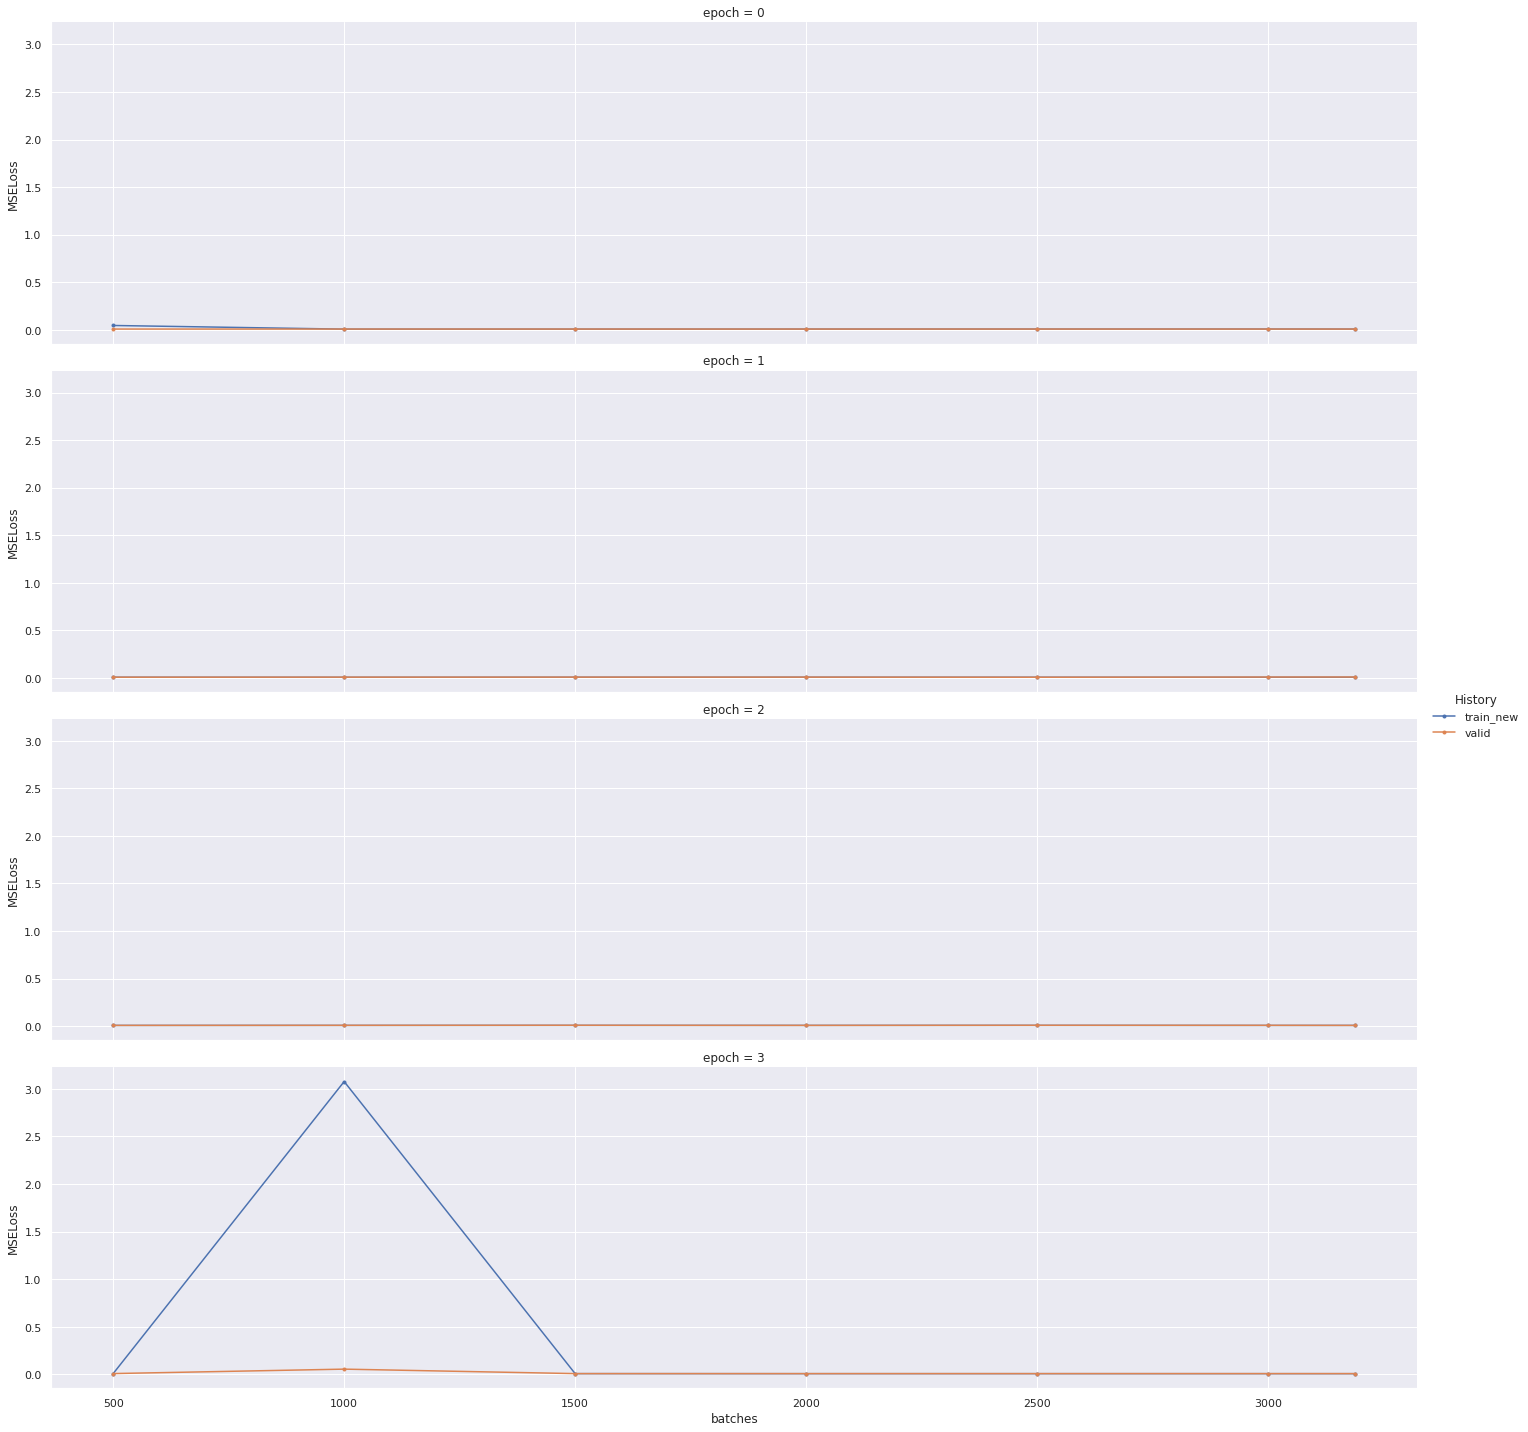

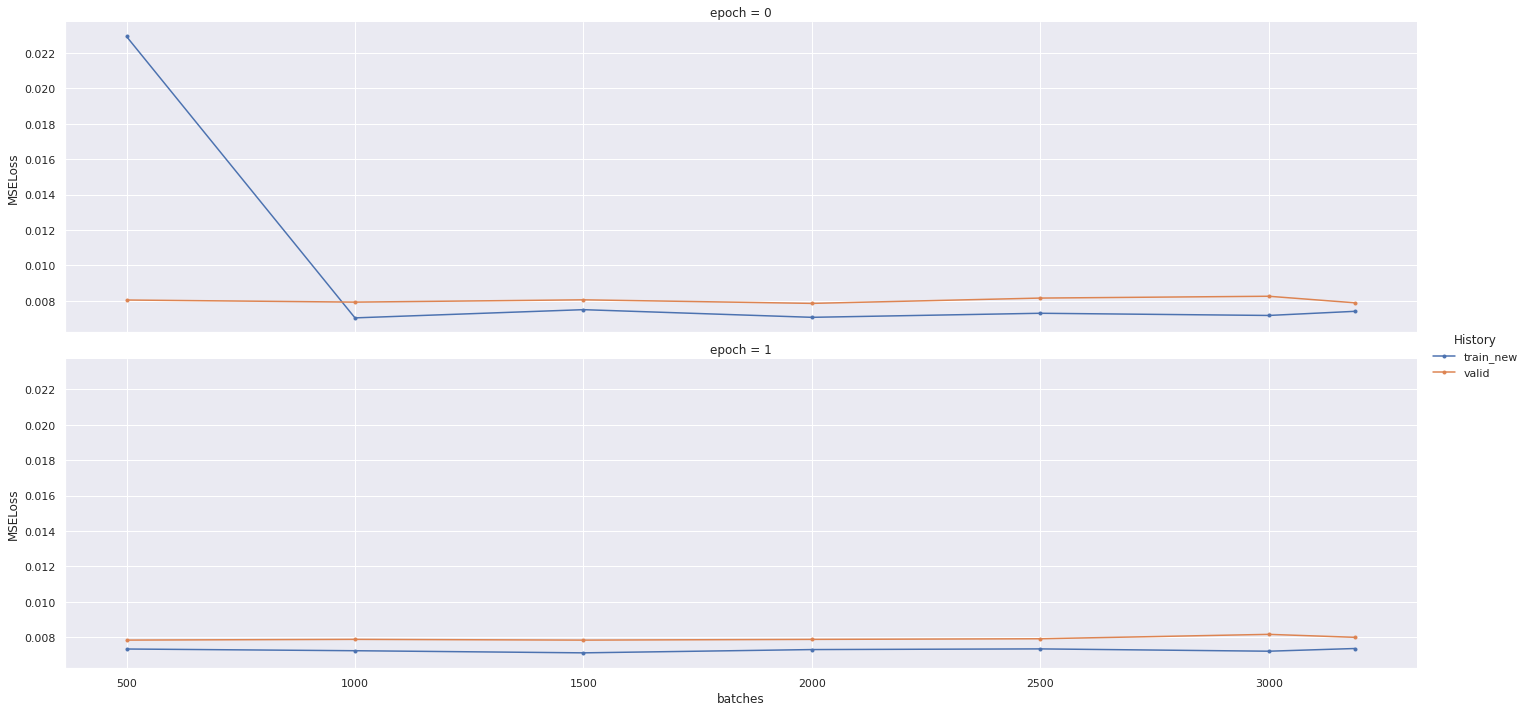

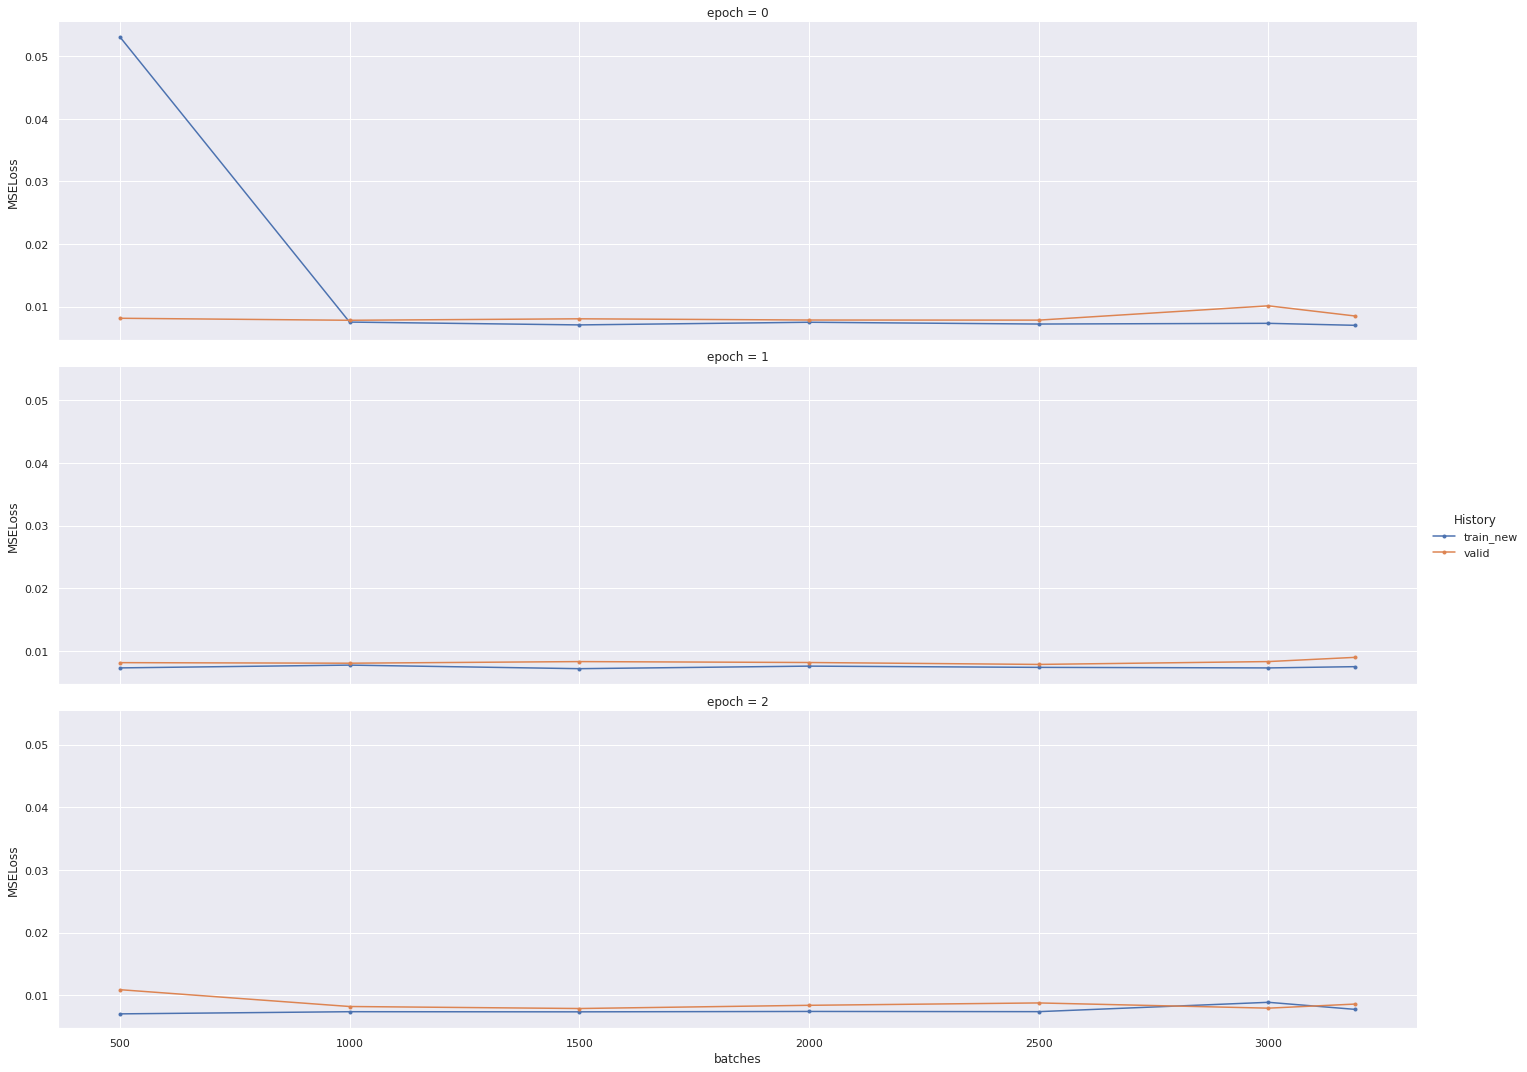

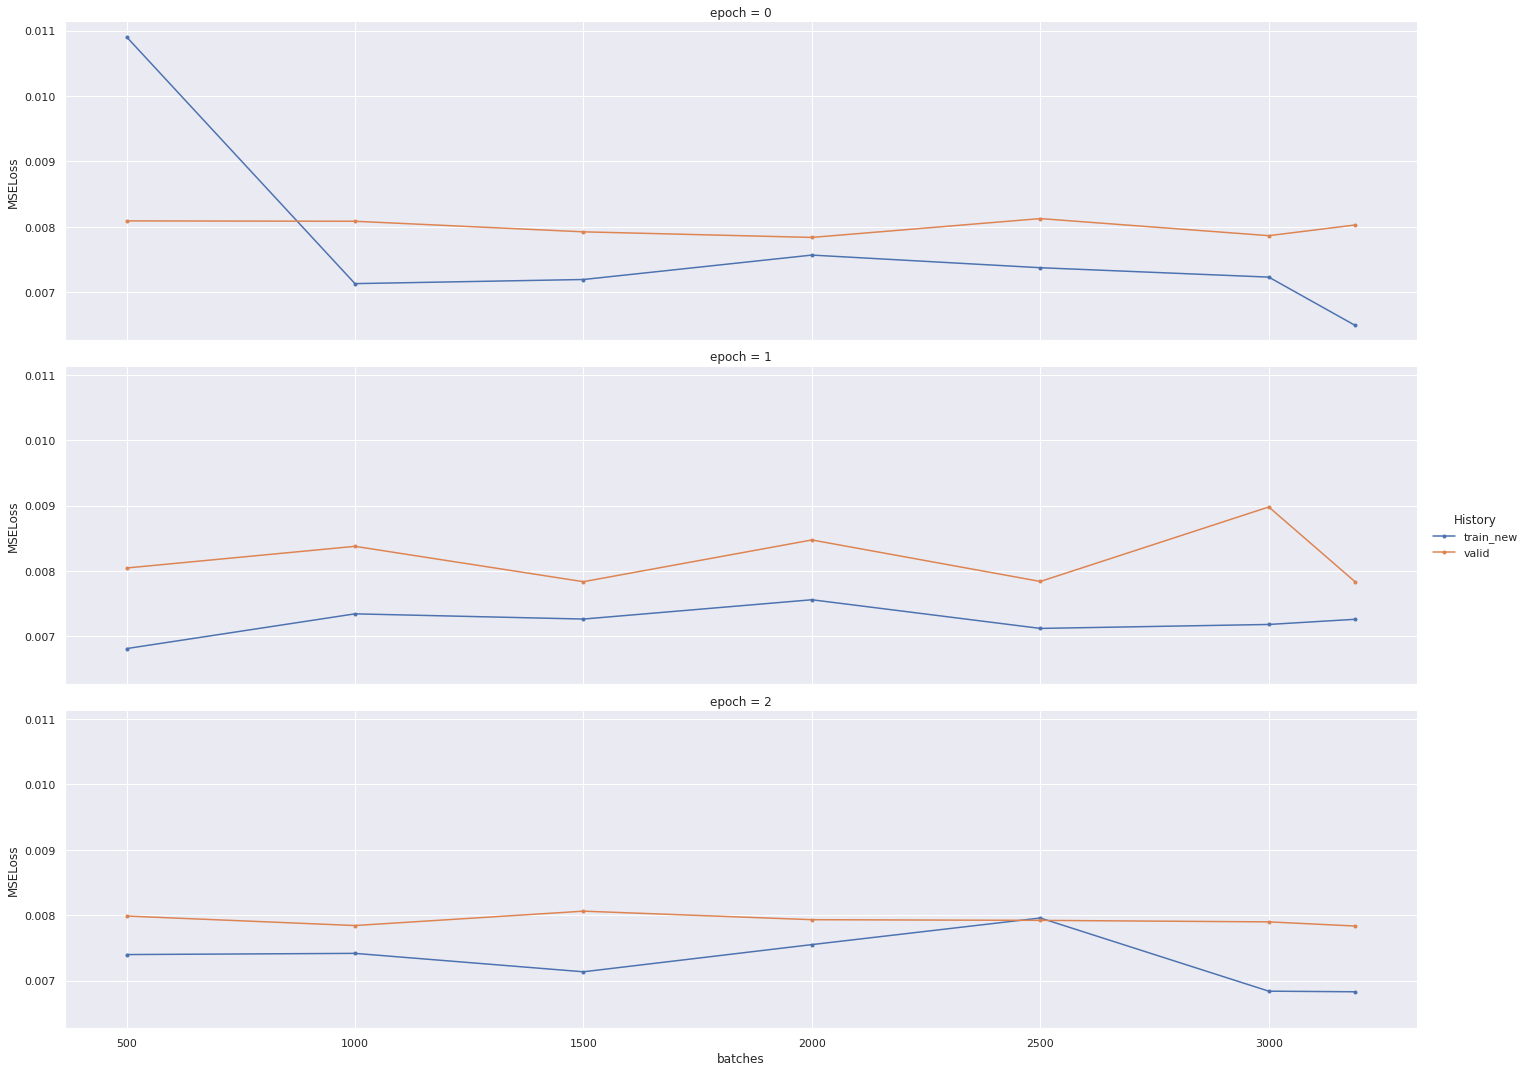

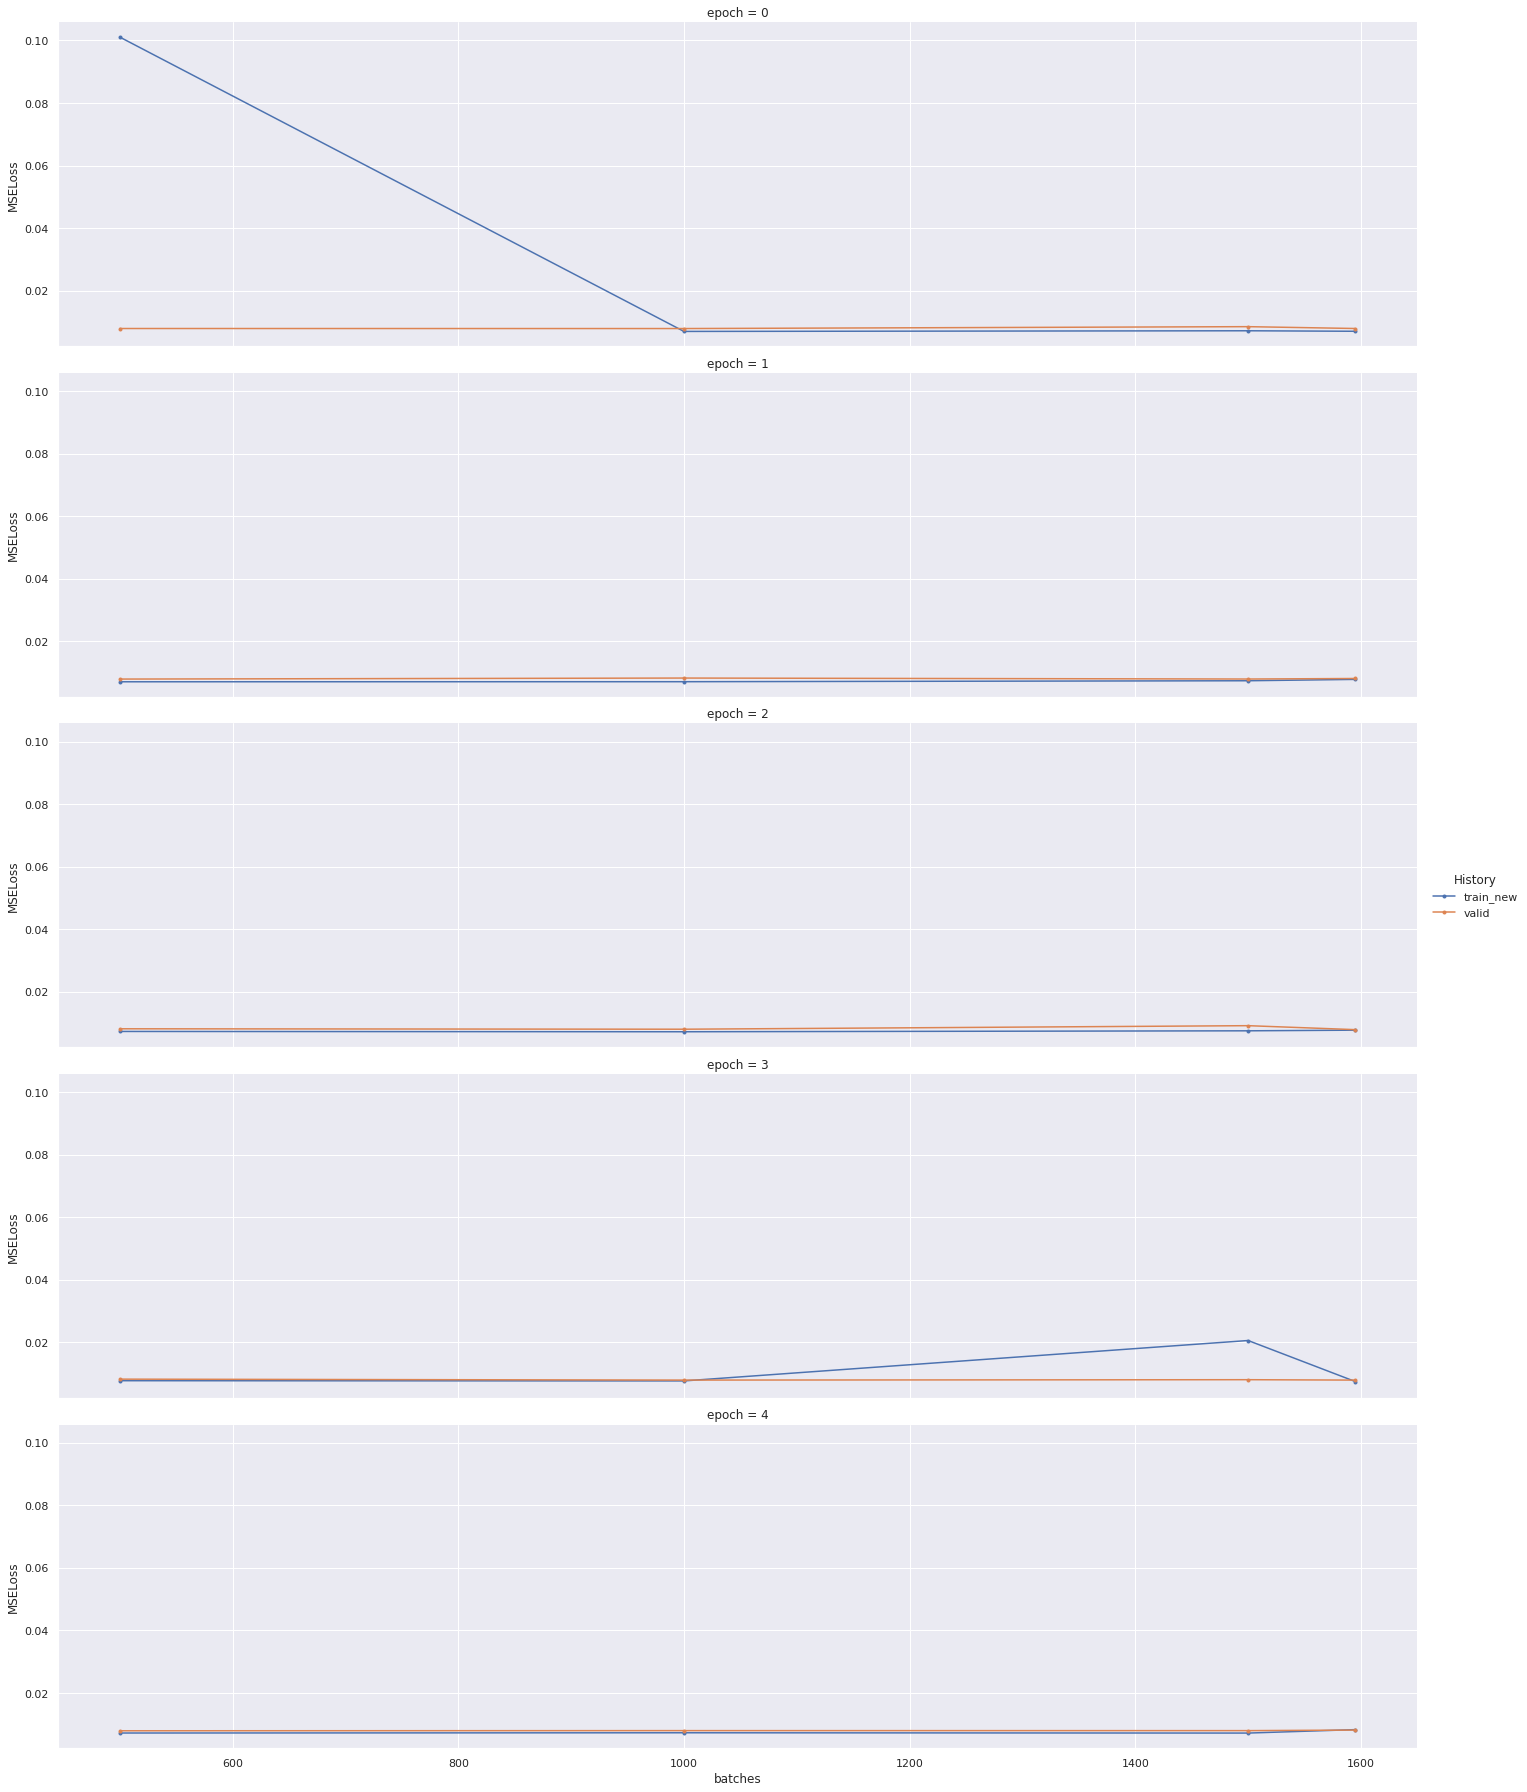

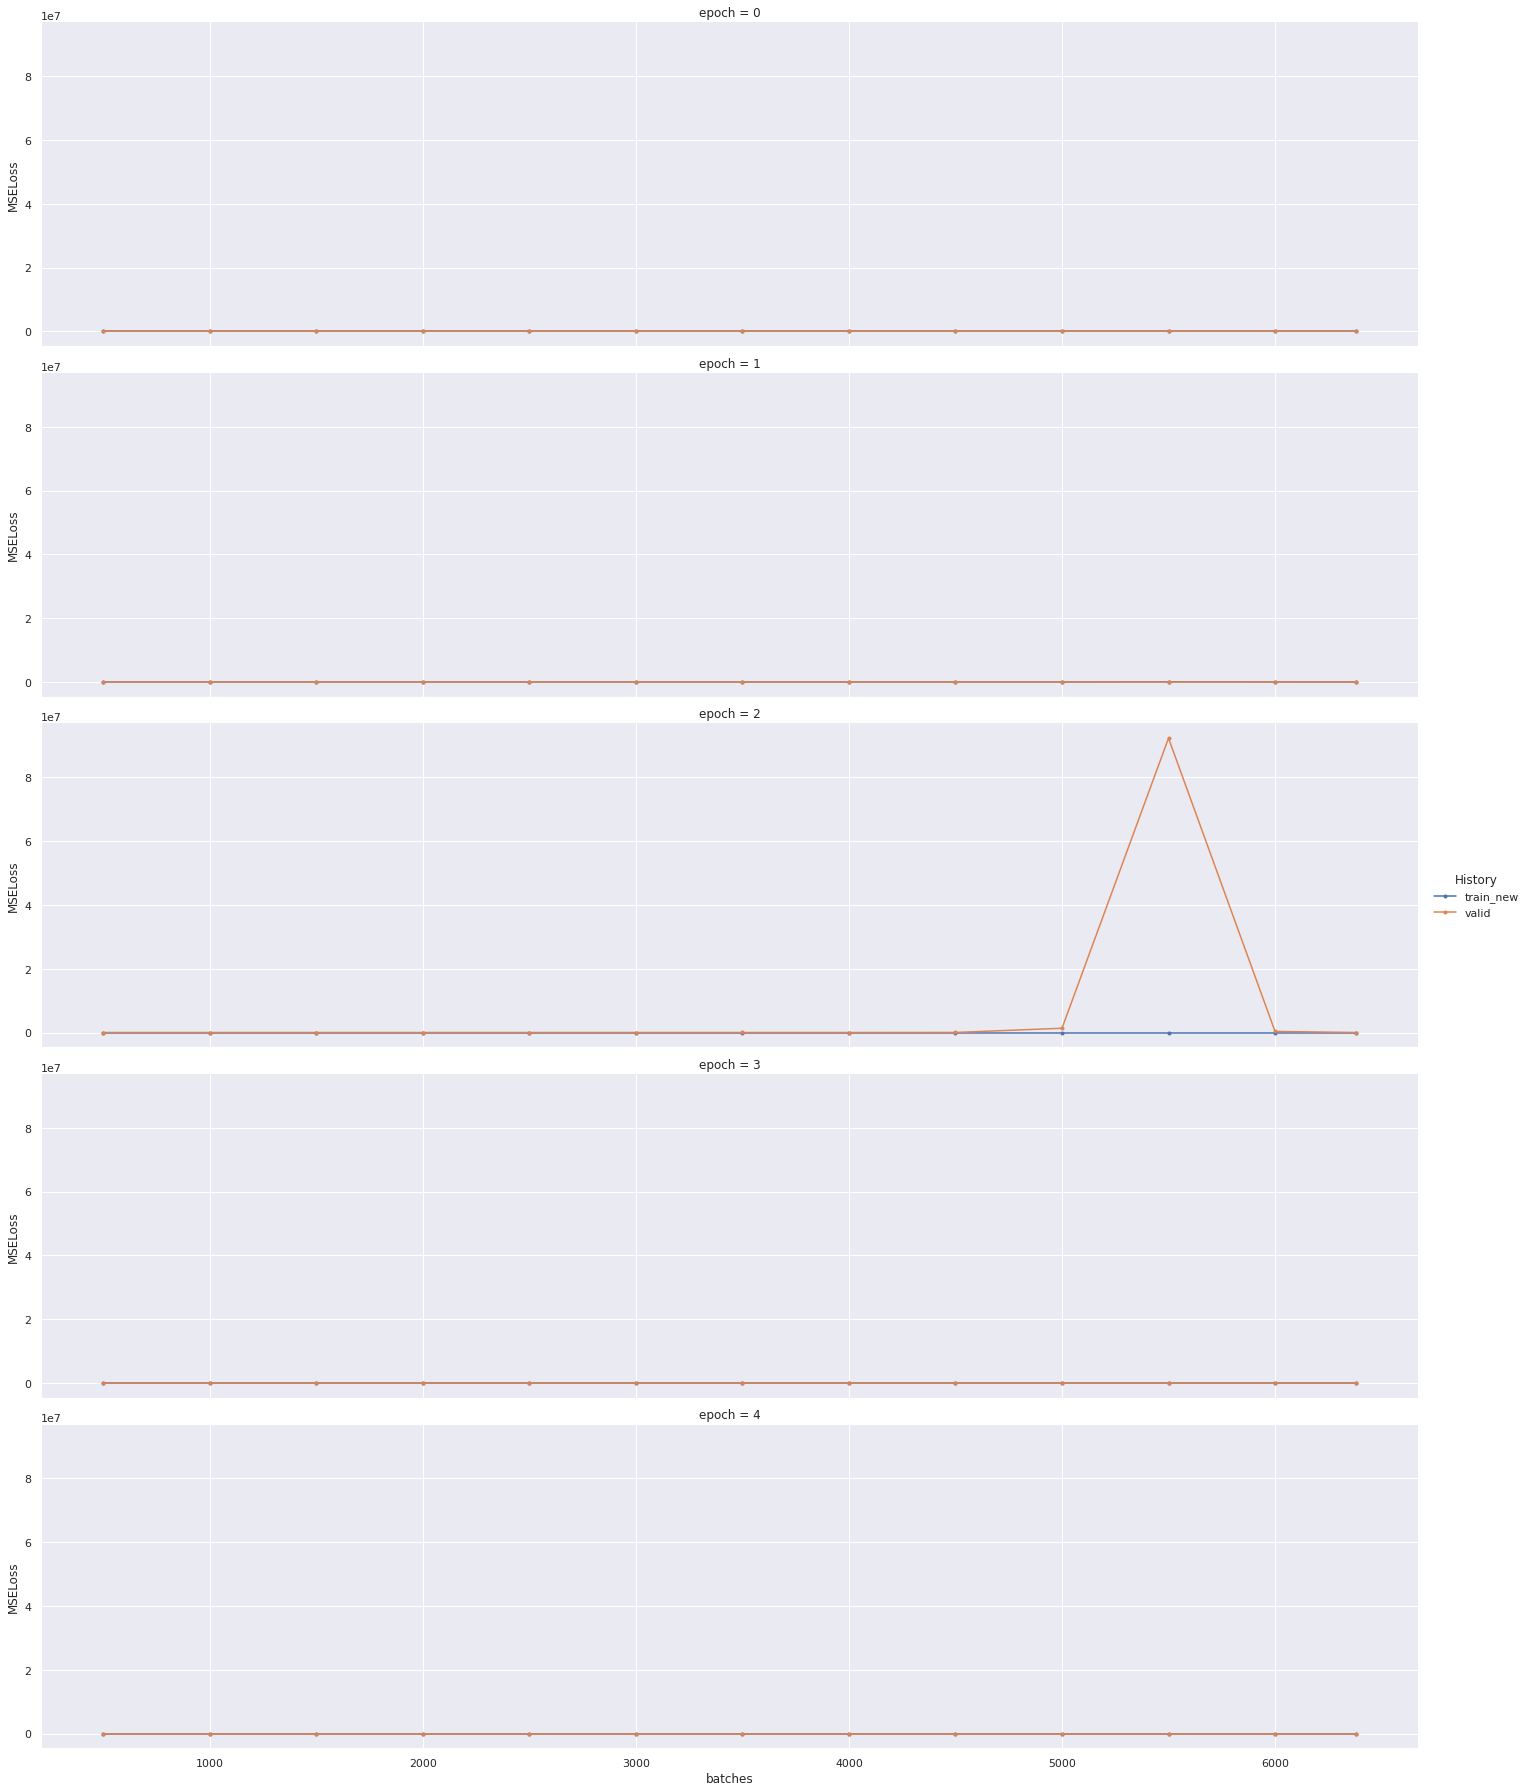

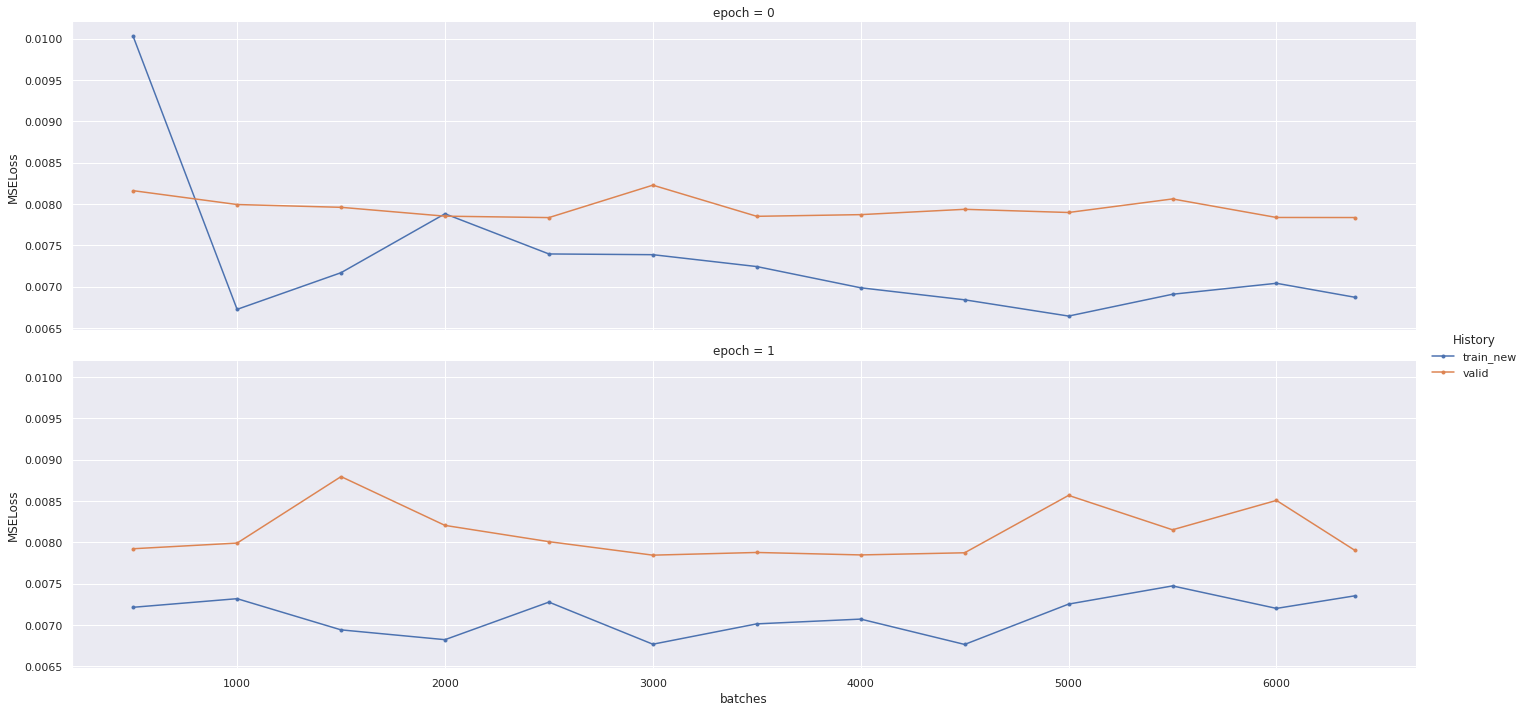

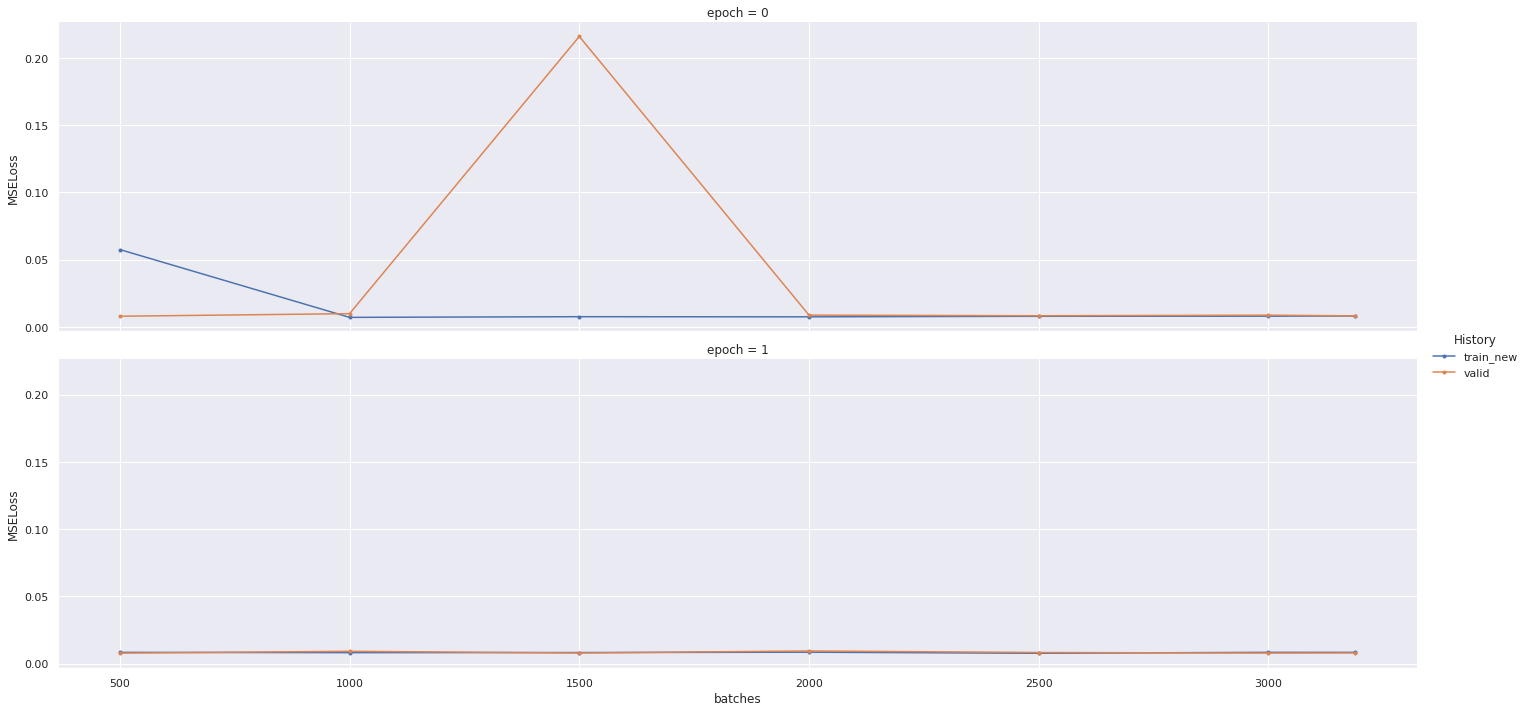

In [ ]:
obj_func = obj_func_gen(train_dataset, valid_dataset, d_embs1, d_embs2, len(num_cols), verbose=2)

optimB = BayesianOptimization(
    f = obj_func,
    pbounds = {'epochs': [2, 5],
               'batch_idx': [7, 9],
               'lins_idx': [4, 6],
               'emb_drop': [0.5, 0.9],
               'ldrop1': [0.5, 0.9],
               'ldrop2': [0.5, 0.9],
               'ldrop3': [0.5, 0.9],
               'lr': [0.05, 1]},
    verbose = 2,
    random_state = 42)

optimB.maximize(init_points=4, n_iter=4)
print(optimB.max)

### 2.3.5 Model performance at tuned hyperparameter

Epoch 0/3 .. Batches 500 .. Train_MSEloss_new 0.015 .. Valid_MSEloss 0.008
Epoch 0/3 .. Batches 1000 .. Train_MSEloss_new 0.008 .. Valid_MSEloss 0.008
Epoch 0/3 .. Batches 1500 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 0/3 .. Batches 2000 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 0/3 .. Batches 2500 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 0/3 .. Batches 3000 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 0/3 .. Batches 3189 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 1/3 .. Batches 500 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 1/3 .. Batches 1000 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 1/3 .. Batches 1500 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 1/3 .. Batches 2000 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 1/3 .. Batches 2500 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 1/3 .. Batches 3000 .. Train_MSEloss_new 0.007 .. Valid_MSEloss 0.008
Epoch 1/3 .. B

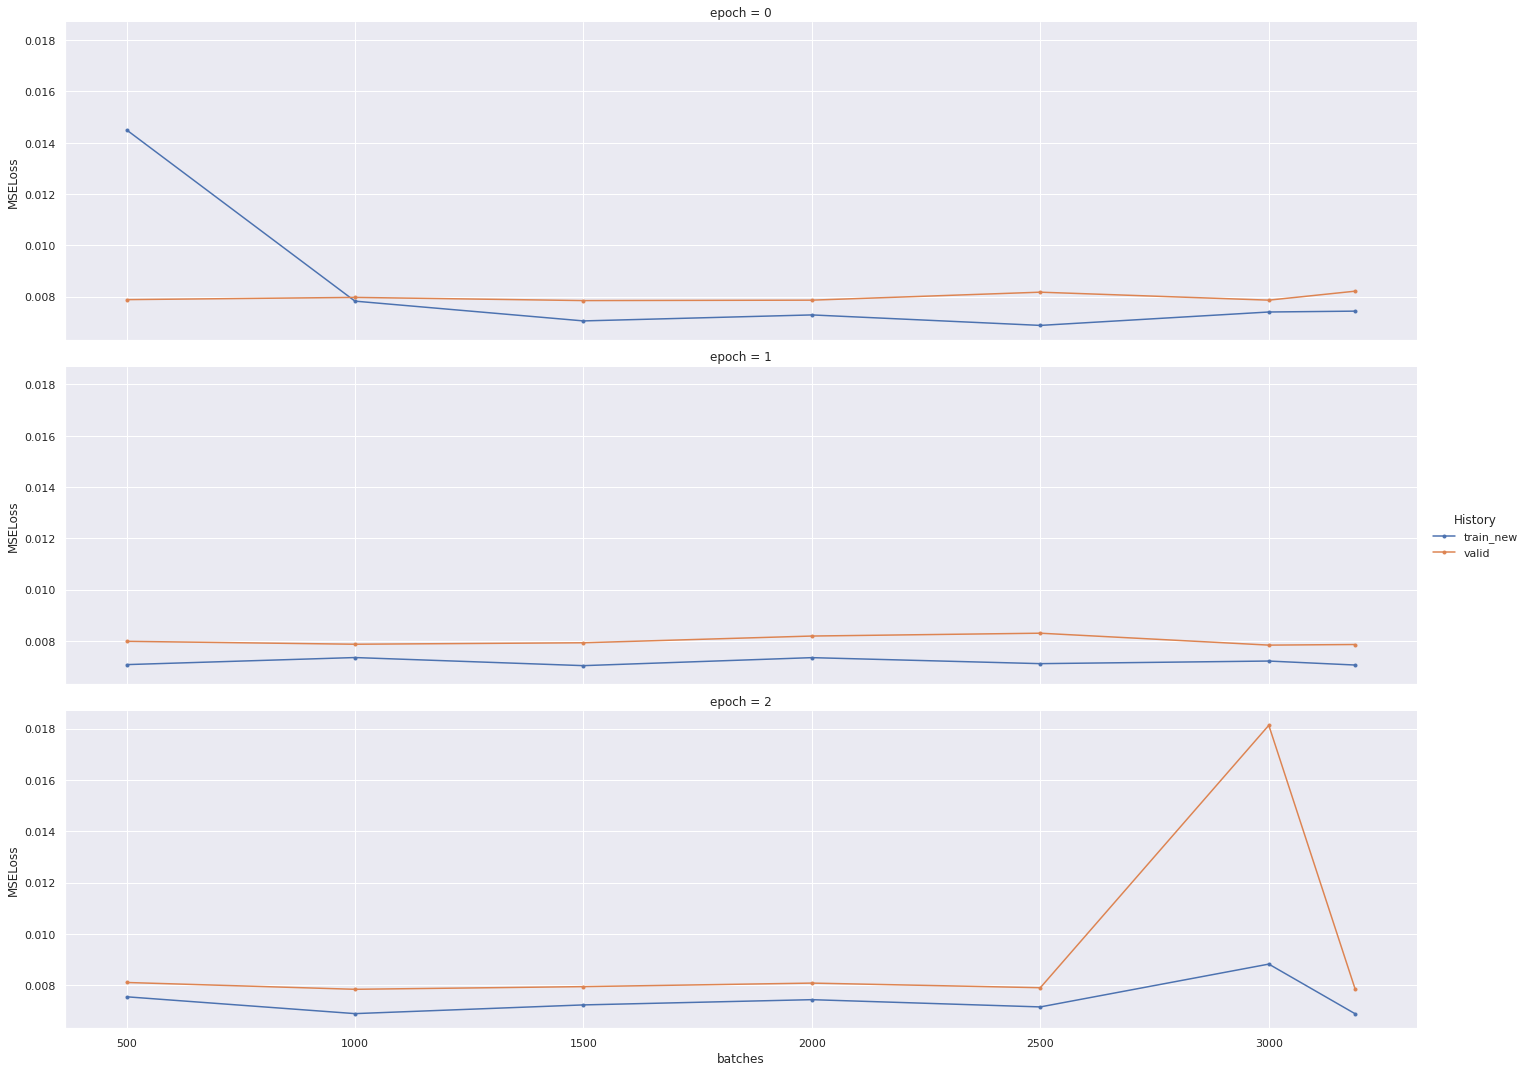

In [ ]:
obj_func = obj_func_gen(train_dataset, valid_dataset, d_embs1, d_embs2, len(num_cols), verbose=2, outModel=True)
#model = obj_func(epochs=5, batch_idx=8, lins_idx=6, emb_drop=0.69, ldrop1=0.77, ldrop2=0.53, ldrop3=0.55, lr=0.01)
vloss, model = obj_func(**optimB.max['params'])

In [ ]:
import math
print(f"rmse of log1p(revenue) over valid data is {num_MinMaxSc.data_range_[3]*math.sqrt(vloss):.3f}")

rmse of log1p(revenue) over valid data is 2.114


In [ ]:
for nm, params in model.named_parameters():
  print(nm, params)

embs1.0.weight Parameter containing:
tensor([[-4.9261e-04,  5.2242e-06,  5.1839e-03,  9.8052e-11, -3.8232e-07],
        [-1.0011e-39, -2.2889e-40, -1.0493e-40, -1.8413e-40, -7.8466e-41],
        [-5.3297e-41, -1.3617e-40, -1.9460e-40, -2.0036e-40, -1.9229e-40],
        [-4.9355e-40,  1.1185e-40,  8.9741e-41,  3.9215e-40,  1.2541e-40],
        [ 1.9244e-40, -3.6075e-41, -1.1588e-40,  2.5253e-40, -1.1961e-40],
        [-1.9344e-40, -3.0154e-40, -8.5876e-40,  1.0164e-40, -7.4364e-40],
        [-5.9873e-41, -8.3616e-18, -6.2782e-40,  1.2339e-03,  4.3816e-40],
        [ 2.7212e-15,  2.8337e-40,  2.9620e-40,  7.6210e-40,  1.9860e-07],
        [ 4.8355e-07, -9.7879e-06,  5.1923e-10,  1.6551e-08, -2.3082e-05]],
       device='cuda:0', requires_grad=True)
embs1.1.weight Parameter containing:
tensor([[ 2.0095e-09,  1.7981e-05, -2.0802e-06,  2.0158e-06,  7.7168e-11,
         -8.8583e-06,  2.2147e-02,  1.7498e-12, -6.2691e-11, -6.0763e-04,
         -6.0370e-05],
        [-9.7504e-41, -4.8450e-40, 

# Part 3: LightGBM model

## 3.0 Import packages

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

## 3.1 Create dataset for lightgbm

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=list(range(len(num_cols), X_train.shape[1])), free_raw_data=False)
lgb_valid = lgb.Dataset(X_valid, y_valid, categorical_feature=list(range(len(num_cols), X_valid.shape[1])), free_raw_data=False)

## 3.2 Bayesian Optimization

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

### 3.2.1 Generate Objective Function

In [ ]:
gbms=[]
def obj_func_lgb(num_leaves, min_child_samples, learning_rate, feature_fraction,\
                 bagging_fraction, bagging_freq, gbms=gbms):
  params = {'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': int(round(num_leaves)),
            'min_child_samples': int(round(min_child_samples)),
            'learning_rate': learning_rate,
            'feature_fraction': feature_fraction,
            'bagging_fraction': bagging_fraction,
            'bagging_freq': int(round(bagging_freq))}
  
  evals_result = {}
  gbm = lgb.train(params,
                  lgb_train,
                  num_boost_round=100,
                  valid_sets=[lgb_train, lgb_valid],
                  early_stopping_rounds=5,
                  evals_result=evals_result,
                  categorical_feature=list(range(len(num_cols), X_train.shape[1])))
  gbms.append(gbm)
  return -evals_result['valid_1']['rmse'][-1]

### 3.2.2 Tune hyper-parameters

In [ ]:
optimLGB = BayesianOptimization(
    f = obj_func_lgb,
    pbounds = {'num_leaves': [25, 35],
               'min_child_samples': [90, 110],
               'learning_rate': [0.01, 0.5],
               'feature_fraction': [0.7, 0.9],
               'bagging_fraction': [0.6, 0.9],
               'bagging_freq': [3, 7]},
    verbose = 2,
    random_state = 42)

optimLGB.maximize(init_points=4, n_iter=4)
print(optimLGB.max)

|   iter    |  target   | baggin... | baggin... | featur... | learni... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	training's rmse: 0.0771249	valid_1's rmse: 0.0817624
Training until validation scores don't improve for 5 rounds.
[2]	training's rmse: 0.0740699	valid_1's rmse: 0.078392
[3]	training's rmse: 0.0719398	valid_1's rmse: 0.0757606
[4]	training's rmse: 0.0707475	valid_1's rmse: 0.0742747
[5]	training's rmse: 0.0698813	valid_1's rmse: 0.0733449
[6]	training's rmse: 0.0693037	valid_1's rmse: 0.0726939
[7]	training's rmse: 0.0690408	valid_1's rmse: 0.0723564
[8]	training's rmse: 0.0687061	valid_1's rmse: 0.0720589
[9]	training's rmse: 0.0684229	valid_1's rmse: 0.0718218
[10]	training's rmse: 0.0682461	valid_1's rmse: 0.0717192
[11]	training's rmse: 0.0680327	valid_1's rmse: 0.0716423
[12]	training's rmse: 0.0678862	valid_1's rmse: 0.0715707
[13]	training's rmse: 0.0677183	valid_1's rmse: 0.0714592
[14]	training's rmse: 0.067632	valid_1's rmse: 0.0714789
[15]	training's rmse: 0.067521	valid_1's rmse: 0.0714713
[16]	training's rmse: 0.0673826	valid_1's rmse: 0.0714675
[17]	training's rmse: 0

In [ ]:
#print(gbms)
gbm = gbms[2]
y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
print("The rmse of log1p revenue over valid dataset is", mean_squared_error(y_valid, y_pred) ** 0.5 * num_MinMaxSc.data_range_[3])


#gbm.save_model('gbm.txt')

The rmse of log1p revenue over valid dataset is 1.6967970940156116


Feature Importance

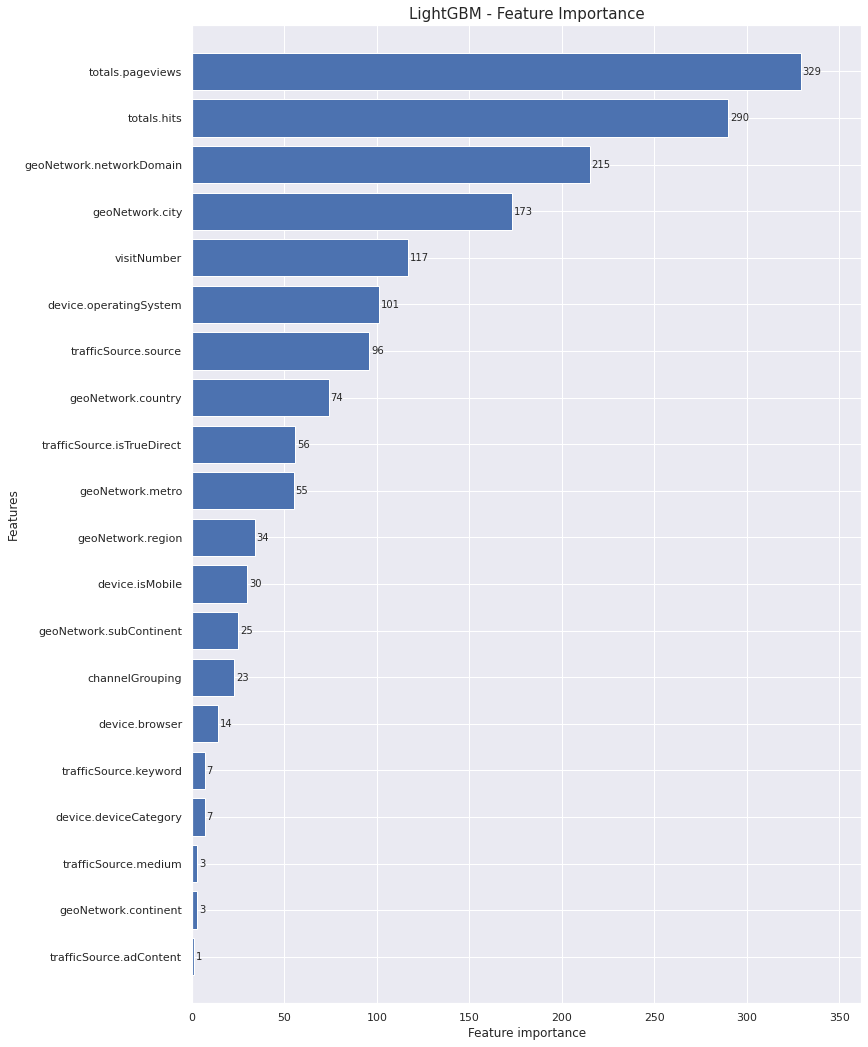

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(gbm, max_num_features=50, height=0.8, ax=ax)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

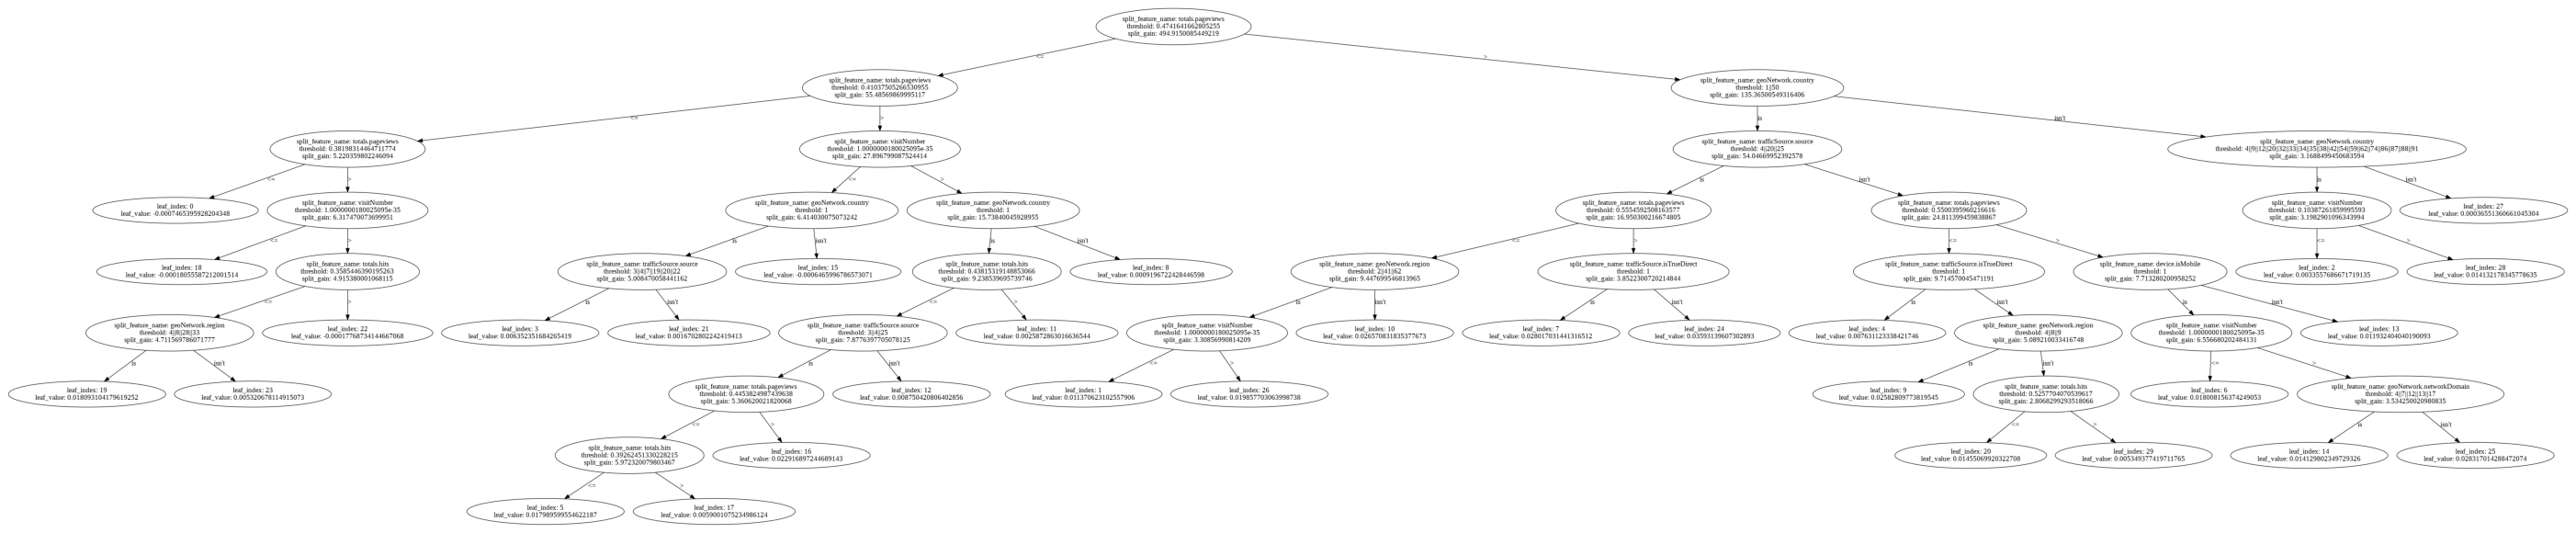

In [ ]:
ax = lgb.plot_tree(gbm, tree_index=2, figsize=(50,50), show_info=['split_gain'])
plt.show()